# Financial Econometrics I: Homework 2
Jan Kubal & Matyáš Mattanelli

## Problem 1

### 1. Loading data

In [1]:
#install.packages(c("fst", "xts", "highfrequency", "stringr", "tseries", "rugarch", "forecast"))
#Loading the packages
suppressPackageStartupMessages({
    library(fst)
    library(xts)
    library(highfrequency)
    library(stringr)
    library(tseries)
    library(rugarch)
    library(forecast)
})

---

Firstly, we load the data, convert it to an xts object, and then store it in the list. In this way, we do not have to rewrite the code for each stock and the ``xts`` package facilitates the manipulation of time series.

In [2]:
#Alternative data reading (into a list)
hw3_data <- vector("list", 3) #Empty vector for the data
list_of_files <- list.files("HW_3_data") #Retrieving the file names
stock_names <- str_match(list_of_files, "HW_3_(.*)_")[, 2] #Saving the stock names
for (i in 1:3) {
    data_holder <- read_fst(paste("HW_3_data/", list_of_files[i], sep = "")) #Reading the data
    hw3_data[[i]] <- xts(data_holder$V1, order.by = data_holder$index) #Turning into xts
}

---

In [2]:
#reading data
data_BAC_full <- read_fst("HW_3_data/HW_3_BAC_1min.fst")
data_MSFT_full <- read_fst("HW_3_data/HW_3_MSFT_1min.fst")
data_XOM_full <- read_fst("HW_3_data/HW_3_XOM_1min.fst")

In [3]:
#basic data exploration, to be removed later
summary(data_BAC_full)
summary(data_MSFT_full)
summary(data_XOM_full)

     index                           V1        
 Min.   :2010-01-04 07:00:00   Min.   : 4.601  
 1st Qu.:2011-11-30 15:15:15   1st Qu.:11.239  
 Median :2013-11-22 10:39:30   Median :14.030  
 Mean   :2013-12-13 06:31:08   Mean   :14.205  
 3rd Qu.:2015-12-24 10:24:45   3rd Qu.:16.056  
 Max.   :2017-12-29 17:59:00   Max.   :29.796  

     index                           V1       
 Min.   :2010-01-04 07:44:00   Min.   :18.43  
 1st Qu.:2011-12-08 08:45:00   1st Qu.:23.52  
 Median :2013-12-18 15:51:00   Median :32.80  
 Mean   :2013-12-27 07:27:58   Mean   :37.81  
 3rd Qu.:2016-01-08 16:04:00   3rd Qu.:48.79  
 Max.   :2017-12-29 18:00:00   Max.   :86.52  

     index                           V1       
 Min.   :2010-01-04 07:01:00   Min.   :43.45  
 1st Qu.:2011-11-28 14:52:30   1st Qu.:65.99  
 Median :2013-12-18 11:05:00   Median :74.10  
 Mean   :2013-12-18 02:42:53   Mean   :71.51  
 3rd Qu.:2015-12-23 12:52:30   3rd Qu.:79.09  
 Max.   :2017-12-29 17:56:00   Max.   :90.13  

In [4]:
sum(is.na(data_BAC_full$V1))
sum(is.na(data_MSFT_full$V1))
sum(is.na(data_XOM_full$V1))

[1] 0

[1] 0

[1] 0

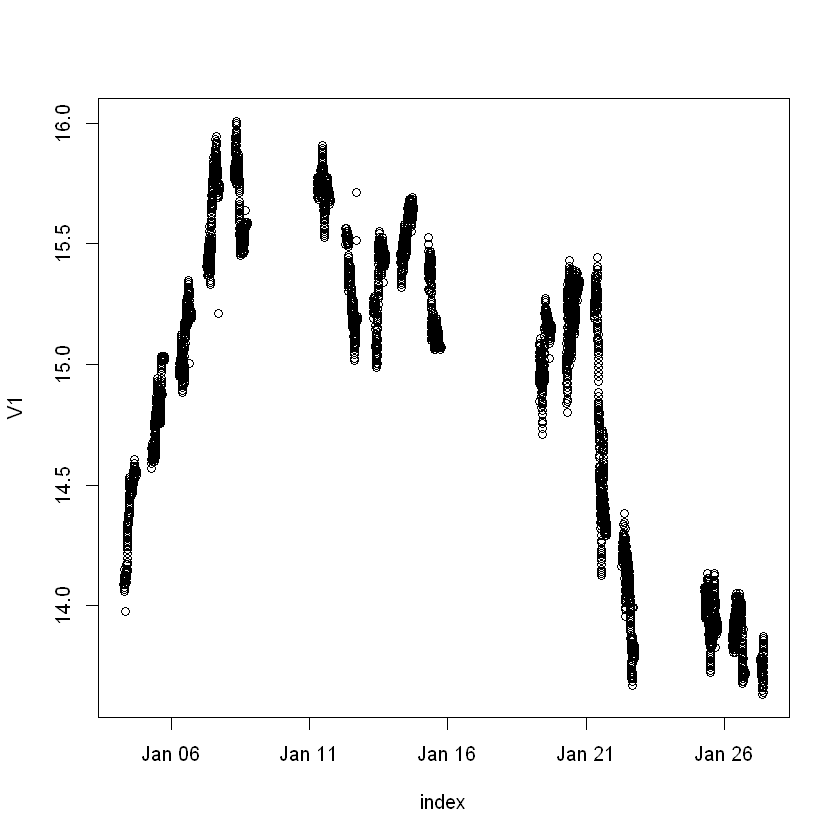

In [40]:
#plot(data_BAC) #<------takes 1 minute to plot
plot(data_BAC_full[1:10000,])

#as usual, we have data on workdays (because stock-exchanges serves need to rest for 2 days XD)

In [41]:
#data_BAC_full[1:100000,]
head(data_BAC_full)
tail(data_BAC_full)

,index,V1
,<dttm>,<dbl>
1,2010-01-04 07:00:00,14.0864
2,2010-01-04 07:04:00,14.0864
3,2010-01-04 07:06:00,14.0679
4,2010-01-04 07:08:00,14.0586
5,2010-01-04 07:13:00,14.0772
6,2010-01-04 07:21:00,14.1050


,index,V1
,<dttm>,<dbl>
1134045,2017-12-29 17:53:00,29.2502
1134046,2017-12-29 17:54:00,29.2403
1134047,2017-12-29 17:56:00,29.2403
1134048,2017-12-29 17:57:00,29.2601
1134049,2017-12-29 17:58:00,29.2403
1134050,2017-12-29 17:59:00,29.2403


### 2. Restricting data

In [5]:
data_BAC <- subset(data_BAC_full, format(data_BAC_full$index,'%Y') >= '2012' & 
                        format(data_BAC_full$index,'%Y') <= '2016' &
                        format(data_BAC_full$index,'%H:%M') >= '09:30' &
                        format(data_BAC_full$index,'%H:%M') <= '16:00')

data_MSFT <- subset(data_MSFT_full, format(data_MSFT_full$index,'%Y') >= '2012' & 
                        format(data_MSFT_full$index,'%Y') <= '2016' &
                        format(data_MSFT_full$index,'%H:%M') >= '09:30' &
                        format(data_MSFT_full$index,'%H:%M') <= '16:00')

data_XOM <- subset(data_XOM_full, format(data_XOM_full$index,'%Y') >= '2012' & 
                        format(data_XOM_full$index,'%Y') <= '2016' &
                        format(data_XOM_full$index,'%H:%M') >= '09:30' &
                        format(data_XOM_full$index,'%H:%M') <= '16:00')                                                


---

Given the functionality of the xts package, we can restrict the series using a simple syntax. 

In [3]:
#Restricting data using xts syntax
hw3_data_restricted <- vector("list", 3) #Empty list for restricted data
for (i in 1:3) {
    data_holder <- hw3_data[[i]]["2012/2016"] #Restricting the years
    hw3_data_restricted[[i]] <- data_holder["T09:30/T16:00"] #Restricting NYSE trading hours
}

---

In [43]:
summary(data_BAC)
head(data_BAC)

     index                           V1        
 Min.   :2012-01-03 09:30:00   Min.   : 5.256  
 1st Qu.:2013-04-05 11:59:30   1st Qu.:11.456  
 Median :2014-07-07 10:19:00   Median :14.291  
 Mean   :2014-07-04 09:45:42   Mean   :13.364  
 3rd Qu.:2015-10-02 12:23:30   3rd Qu.:15.624  
 Max.   :2016-12-30 16:00:00   Max.   :22.841  

,index,V1
,<dttm>,<dbl>
296344,2012-01-03 09:30:00,5.3773
296345,2012-01-03 09:31:00,5.3773
296346,2012-01-03 09:32:00,5.3960
296347,2012-01-03 09:33:00,5.4147
296348,2012-01-03 09:34:00,5.4240
296349,2012-01-03 09:35:00,5.4334


### 3. Getting intraday 1-minute returns

In [44]:
#This works, but is slow :( ... cca an hour per ticker

days <- unique(format(data_BAC$index,'%Y-%m-%d')) #get the vector of unique days
BAC_intr_returns <- data.frame(index = data_BAC$index, ret = vector("numeric", length(data_BAC$index))) #dataframe to hold returns, has column of days and empty numeric col.

for (d in days[1:5]) { #restrict days to small sample, just to see if it works well
   day_data <- data_BAC[format(data_BAC$index, '%Y-%m-%d') == d,] #get the price data for a specific day

   day_returns <- rbind(c(NA, NA), sapply(day_data, function(p) {diff(p, lag = 1)/lag(p)})) #get the returns on that day, insert first NA/NA row



   BAC_intr_returns$ret[format(data_BAC$index, '%Y-%m-%d') == d] <- day_returns[-nrow(day_returns):-nrow(day_returns),2] #save returns (chop off the last row for matching lengths)

   print(paste("Finished returns on", d, sep = "")) #just to know how long it will take
}

Warning message in FUN(X[[i]], ...):
"Incompatible methods ("/.difftime", "Ops.POSIXt") for "/""
Warning message in diff(p, lag = 1)/lag(p):
"longer object length is not a multiple of shorter object length"
Warning message in diff(p, lag = 1)/lag(p):
"longer object length is not a multiple of shorter object length"


[1] "Finished returns on2012-01-03"


Warning message in FUN(X[[i]], ...):
"Incompatible methods ("/.difftime", "Ops.POSIXt") for "/""
Warning message in diff(p, lag = 1)/lag(p):
"longer object length is not a multiple of shorter object length"
Warning message in diff(p, lag = 1)/lag(p):
"longer object length is not a multiple of shorter object length"


[1] "Finished returns on2012-01-04"


Warning message in FUN(X[[i]], ...):
"Incompatible methods ("/.difftime", "Ops.POSIXt") for "/""
Warning message in diff(p, lag = 1)/lag(p):
"longer object length is not a multiple of shorter object length"
Warning message in diff(p, lag = 1)/lag(p):
"longer object length is not a multiple of shorter object length"


[1] "Finished returns on2012-01-05"


Warning message in FUN(X[[i]], ...):
"Incompatible methods ("/.difftime", "Ops.POSIXt") for "/""
Warning message in diff(p, lag = 1)/lag(p):
"longer object length is not a multiple of shorter object length"
Warning message in diff(p, lag = 1)/lag(p):
"longer object length is not a multiple of shorter object length"


[1] "Finished returns on2012-01-06"


Warning message in FUN(X[[i]], ...):
"Incompatible methods ("/.difftime", "Ops.POSIXt") for "/""
Warning message in diff(p, lag = 1)/lag(p):
"longer object length is not a multiple of shorter object length"
Warning message in diff(p, lag = 1)/lag(p):
"longer object length is not a multiple of shorter object length"


[1] "Finished returns on2012-01-09"


In [45]:
print(data.frame(BAC_intr_returns, data_BAC)) #in text editor it can be manually checked that it works

                     index          ret             index.1     V1
296344 2012-01-03 09:30:00           NA 2012-01-03 09:30:00 5.3773
296345 2012-01-03 09:31:00  0.000000000 2012-01-03 09:31:00 5.3773
296346 2012-01-03 09:32:00  0.003477582 2012-01-03 09:32:00 5.3960
296347 2012-01-03 09:33:00  0.003465530 2012-01-03 09:33:00 5.4147
296348 2012-01-03 09:34:00  0.001717547 2012-01-03 09:34:00 5.4240
296349 2012-01-03 09:35:00  0.001733038 2012-01-03 09:35:00 5.4334
296350 2012-01-03 09:36:00 -0.001730040 2012-01-03 09:36:00 5.4240
296351 2012-01-03 09:37:00  0.000000000 2012-01-03 09:37:00 5.4240
296352 2012-01-03 09:38:00  0.001733038 2012-01-03 09:38:00 5.4334
296353 2012-01-03 09:39:00  0.000000000 2012-01-03 09:39:00 5.4334
296354 2012-01-03 09:40:00  0.000000000 2012-01-03 09:40:00 5.4334
296355 2012-01-03 09:41:00 -0.001730040 2012-01-03 09:41:00 5.4240
296356 2012-01-03 09:42:00 -0.001714602 2012-01-03 09:42:00 5.4147
296357 2012-01-03 09:43:00  0.000000000 2012-01-03 09:43:00 5.

In [46]:
## Much simpler way of getting the intraday data (three cells, one for each stock)

#length(c(NA, diff(data_BAC$V1))/lag(data_BAC$V1)) #match this vector with timestamps and replace data on 9:30 with NA
BAC_intr_returns <- data.frame(data_BAC, ret = c(NA, diff(data_BAC$V1))/lag(data_BAC$V1))
BAC_intr_returns$ret[format(BAC_intr_returns$index, '%H:%M') == '09:30'] <- NA #same result as the for loop above, but much simpler
#print(BAC_intr_returns) #again manual inspection

In [47]:
MSFT_intr_returns <- data.frame(data_MSFT, ret = c(NA, diff(data_MSFT$V1))/lag(data_MSFT$V1))
MSFT_intr_returns$ret[format(MSFT_intr_returns$index, '%H:%M') == '09:30'] <- NA
#print(MSFT_intr_returns)

In [48]:
XOM_intr_returns <- data.frame(data_XOM, ret = c(NA, diff(data_XOM$V1))/lag(data_XOM$V1))
XOM_intr_returns$ret[format(XOM_intr_returns$index, '%H:%M') == '09:30'] <- NA
#print(MSFT_intr_returns)

---

To calculate the intraday returns we firstly adjust the ``makeReturns`` function to set the first observation to NA rather than zero since we do not want to bias the results. We then apply the function on the data split into individual days. Lastly, we merge the series back together. 

In [4]:
#Alternative way to calculate intraday returns
hw3_data_final <- vector("list", 3) #Empty vector for final data
makeReturns_adjusted <- function(xts_object) { #A function to prevent the makeReturns function to set first row to zero
    result <- makeReturns(xts_object) #Call the function and save the resulting returns
    result[1] <- NA #Replace the zero in first row with NA
    return(result)
}
for (i in 1:3) { #Looping through the stocks
    days <- split(hw3_data_restricted[[i]], f = "days") #Splitting the series into days
    intraday_returns <- lapply(X = days, FUN = makeReturns_adjusted) #Calculating the returns for each day
    hw3_data_final[[i]] <- do.call(rbind.xts, intraday_returns) #Concatenating the series
}

---

### 4. Examining the behavior of rCov() function

In [49]:
#install.packages("highfrequency")
library(highfrequency)
library(xts)

In [61]:
rcov_xts <- as.xts(BAC_intr_returns[,2:3], order.by = BAC_intr_returns$index) #it seems that rCov() needs to get data in xts object, so here we save data in xts


In [51]:
#saving output of rCov(), first price -> returns -> RV, then returns -> RV
rcov_prices <- rCov(rcov_xts$V1, makeReturns = TRUE)
rcov_returns <- rCov(na.omit(rcov_xts$ret), makeReturns = FALSE) #it had problem with NAs, so I ommited them

In [52]:
nrow(rcov_xts)
nrow(rcov_prices) #<- one observation per day, as Realized Variance is daily measure
nrow(rcov_returns)

[1] 490419

[1] 1258

[1] 1258

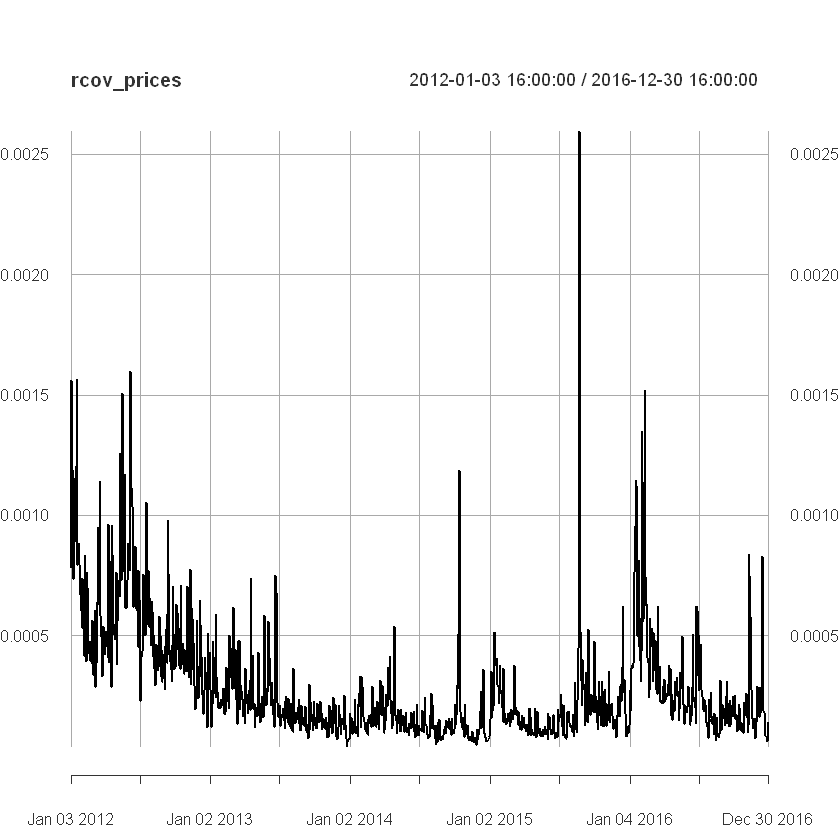

In [53]:
plot(rcov_prices)

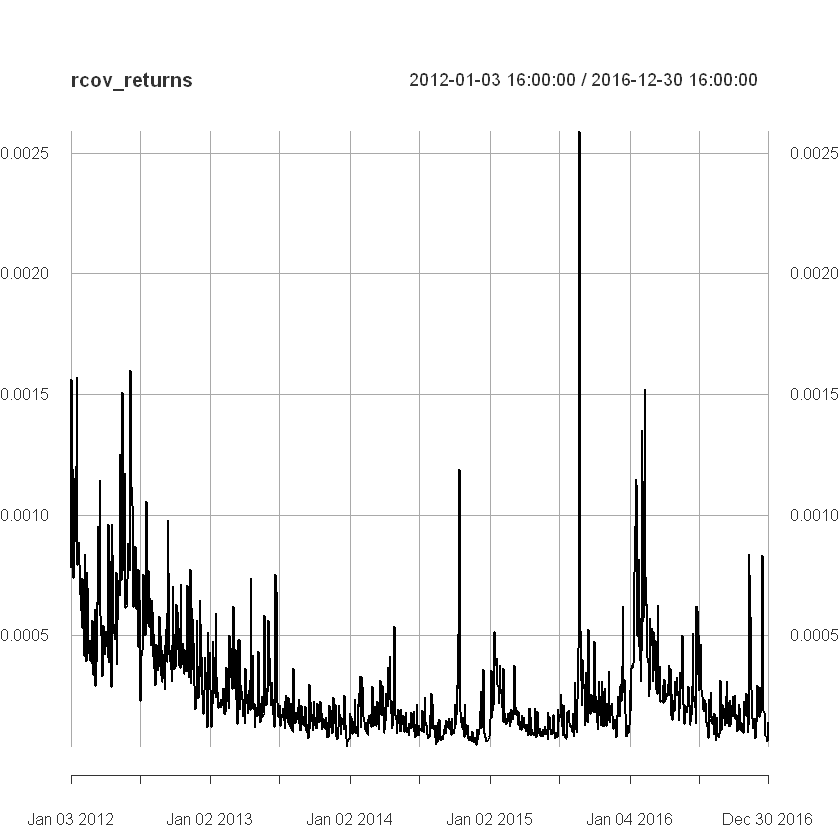

In [54]:
plot(rcov_returns)

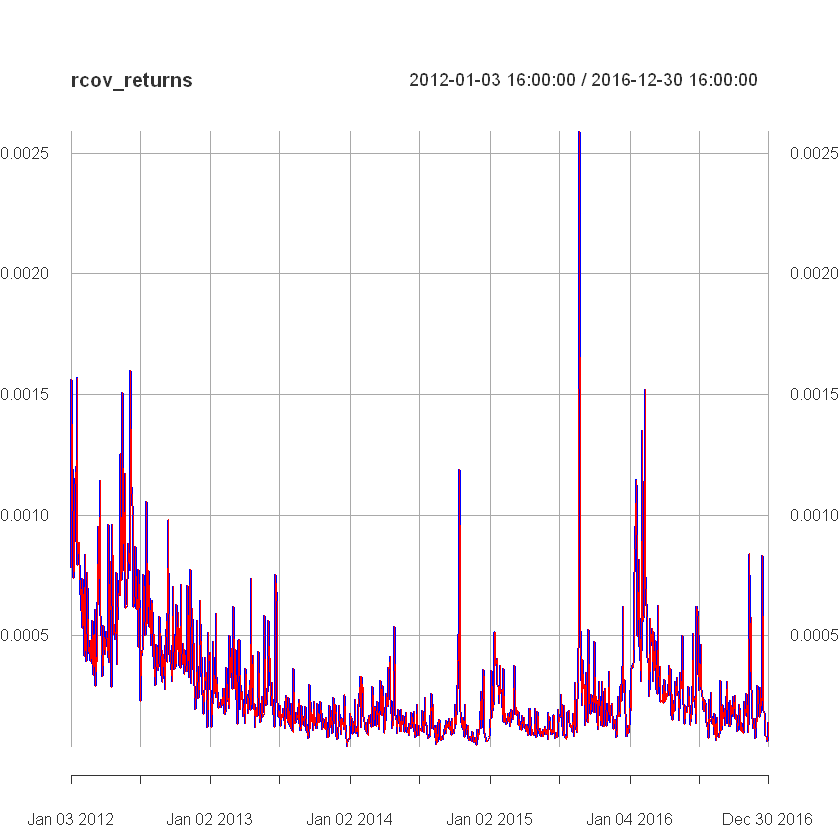

In [68]:
plot <- plot(rcov_returns, col = "blue")
lines(rcov_prices, col= "red") # they seem to be almost the same, let's take a look at summary and differences

In [71]:
summary(rcov_returns)
summary(rcov_prices) #median and 1st and 3rd quantiles differ slightly

     Index                          ret           
 Min.   :2012-01-03 16:00:00   Min.   :0.0000410  
 1st Qu.:2013-04-06 10:00:00   1st Qu.:0.0001343  
 Median :2014-07-05 15:59:30   Median :0.0002046  
 Mean   :2014-07-04 12:00:43   Mean   :0.0002894  
 3rd Qu.:2015-10-02 10:00:00   3rd Qu.:0.0003651  
 Max.   :2016-12-30 16:00:00   Max.   :0.0025905  

     Index                           V1           
 Min.   :2012-01-03 16:00:00   Min.   :0.0000410  
 1st Qu.:2013-04-06 10:00:00   1st Qu.:0.0001344  
 Median :2014-07-05 15:59:30   Median :0.0002045  
 Mean   :2014-07-04 12:00:43   Mean   :0.0002894  
 3rd Qu.:2015-10-02 10:00:00   3rd Qu.:0.0003645  
 Max.   :2016-12-30 16:00:00   Max.   :0.0025965  

In [72]:
summary(rcov_returns$ret-rcov_prices$V1) #we can see there are differences

     Index                          ret            
 Min.   :2012-01-03 16:00:00   Min.   :-5.979e-06  
 1st Qu.:2013-04-06 10:00:00   1st Qu.:-3.323e-08  
 Median :2014-07-05 15:59:30   Median : 3.881e-09  
 Mean   :2014-07-04 12:00:43   Mean   : 2.546e-09  
 3rd Qu.:2015-10-02 10:00:00   3rd Qu.: 4.646e-08  
 Max.   :2016-12-30 16:00:00   Max.   : 3.874e-06  

In [ ]:
## It should be probably done for other tickers as well...just copying the code...I was lazy to do that so far :/

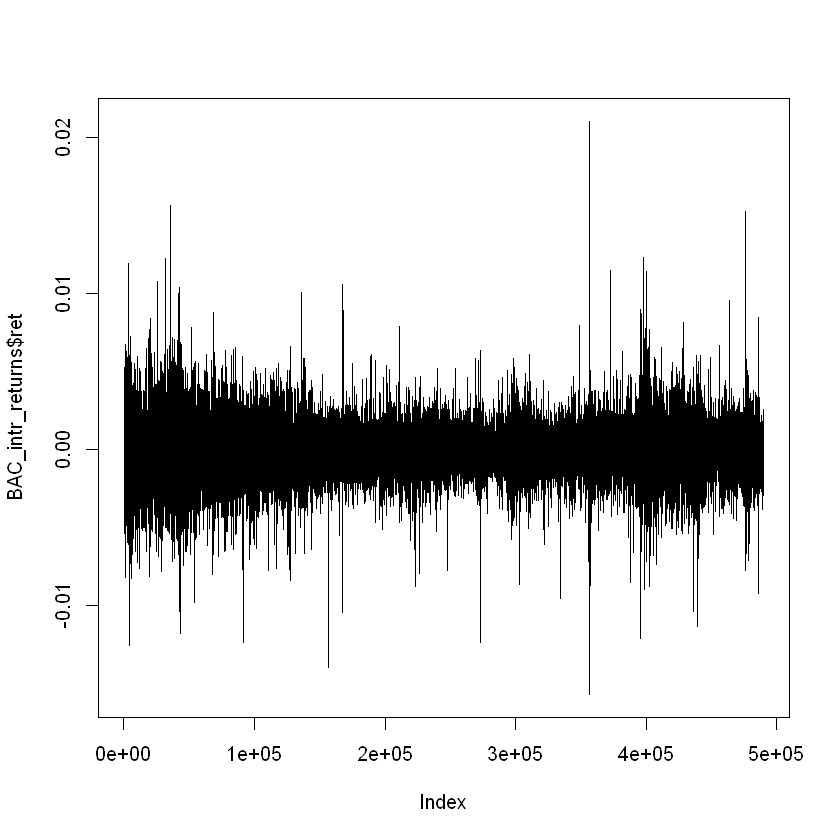

In [55]:
#just interested in the returns:
plot(BAC_intr_returns$ret, type = "l")

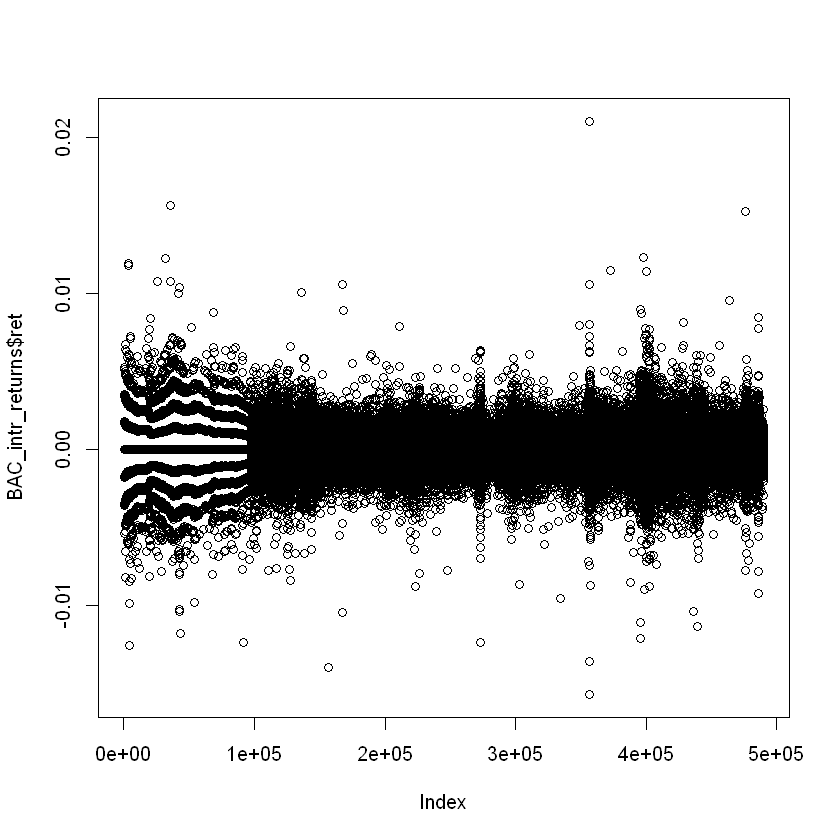

In [56]:
#but look at this, this is weird, whats that patern at the first year?
plot(BAC_intr_returns$ret)
#perhaps there are only some fixed options the BIDers and ASKers can choose?

---

In order to inspect the behavior of the ``rCov`` function, we firstly calculate the Realized Variance from raw prices setting ``makeReturns=TRUE``.

In [5]:
#Calculating the Realized Variance from prices
real_var_from_prices <- vector("list", 3) #Empty vector for the results
for (i in 1:3) {#Looping through the tickers
    real_var_from_prices[[i]] <- rCov(hw3_data_restricted[[i]], makeReturns = TRUE)
}

Then we calculate RV from manually calculated returns...

In [20]:
#Calculating the Realized Variance from returns
real_var_from_returns <- vector("list", 3) #Empty vector for the results
for (i in 1:3) {#Looping through the tickers
    real_var_from_returns[[i]] <- rCov(na.omit(hw3_data_final[[i]]), makeReturns = FALSE) #Have to omit NAs in order for the function to work
}

...and compare the results.

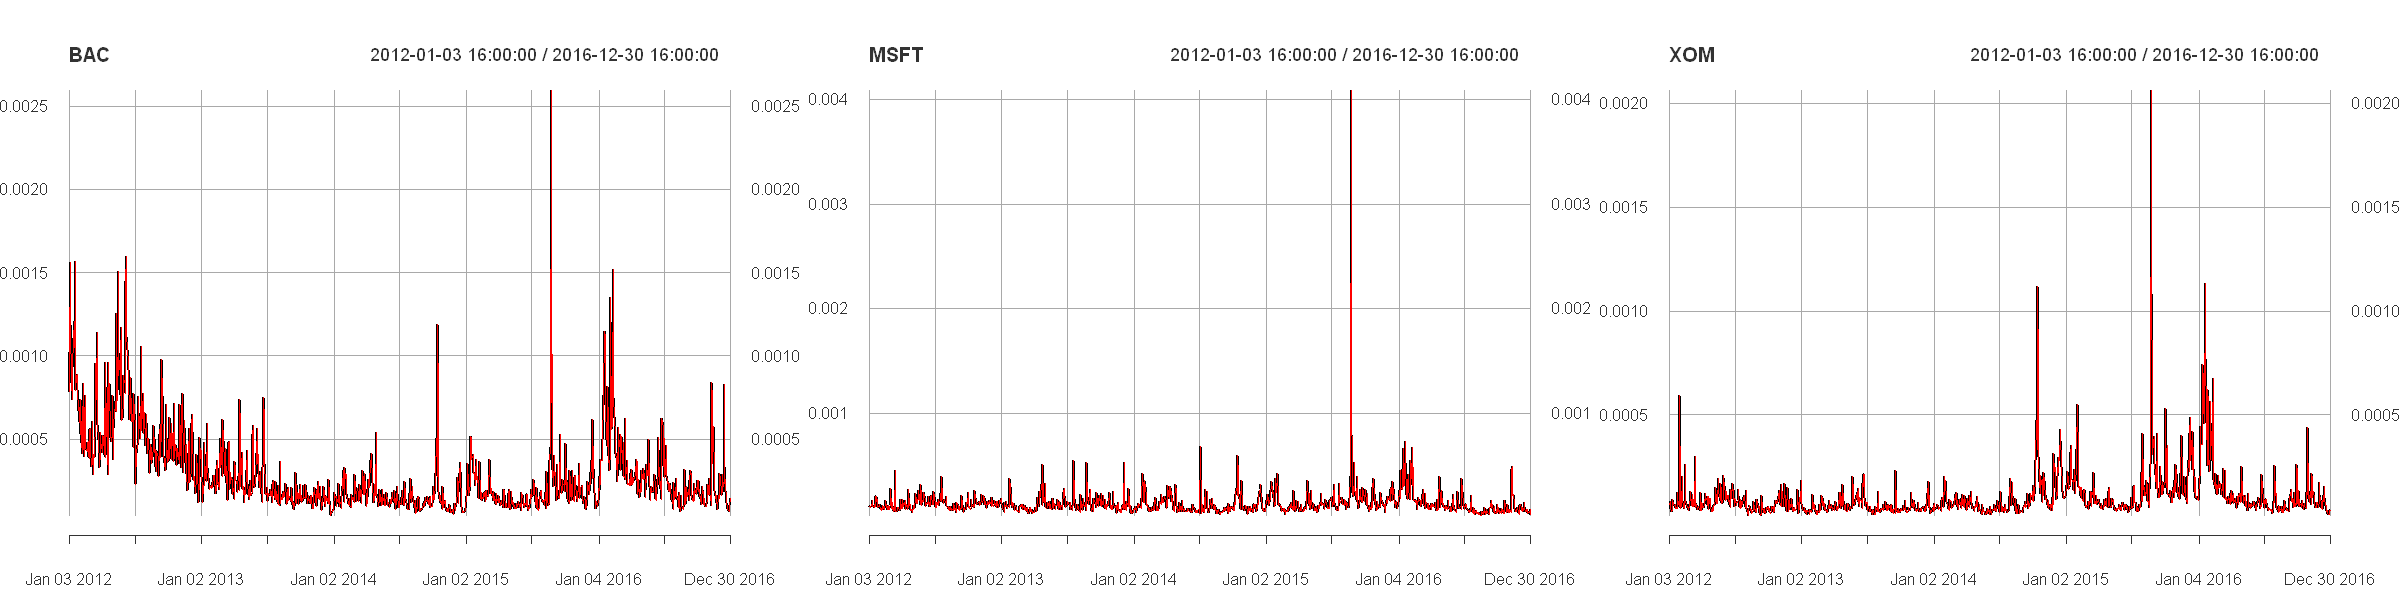

In [7]:
#Plotting the results
par(mfrow = c(1, 3)) #Setting up the grid
options(repr.plot.width = 20, repr.plot.height = 5) #Enlarging the plot
for (i in 1:3) {#Looping through the stocks
    plot_holder <- plot(real_var_from_prices[[i]], main = stock_names[i]) #Plotting Realized Variance calculated from prices
    plot_holder <- lines(real_var_from_returns[[i]], col = "red") #Adding Realized Variance calculated from returns for comparison
    print(plot_holder)
}

From the plots it seems that the series are identical. We can verify that by plotting their difference.

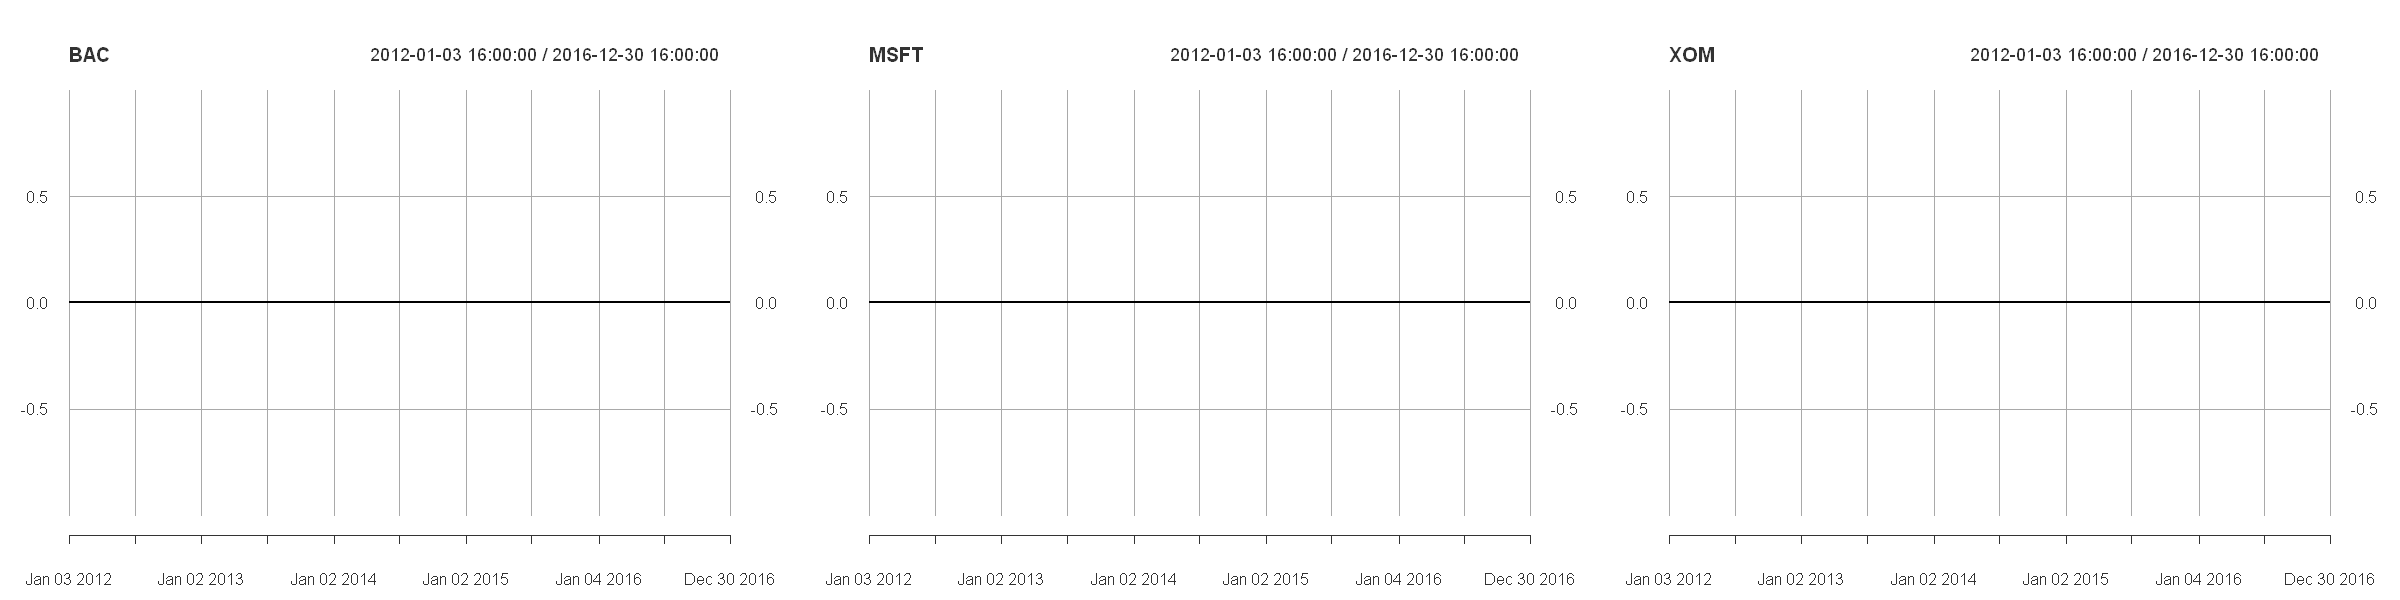

In [8]:
#Plotting the differences
par(mfrow = c(1, 3))
for (i in 1:3) {
    print(plot(real_var_from_prices[[i]] - real_var_from_returns[[i]], main = stock_names[i]))
}
#No difference, they are the same


There seem to be no difference. That would suggest that both procedures arrive to identical results.

---

### 5. Realized Variance for intraday sub-periods

In [ ]:
#dividing data to thre intraday sub-periods
#BAC
#period 1
BAC_intr_returns_subset1 <- subset(BAC_intr_returns, format(BAC_intr_returns$index, '%H:%M') >= '09:30' &
                                                    format(BAC_intr_returns$index, '%H:%M') <= '10:59')
BAC_ir_sub1_xts <- as.xts(BAC_intr_returns_subset1$ret, order.by = BAC_intr_returns_subset1$index)

#period 2
BAC_intr_returns_subset2 <- subset(BAC_intr_returns, format(BAC_intr_returns$index, '%H:%M') >= '11:00' &
                                                    format(BAC_intr_returns$index, '%H:%M') <= '14:29')
BAC_ir_sub2_xts <- as.xts(BAC_intr_returns_subset2$ret, order.by = BAC_intr_returns_subset2$index)

#period 3
BAC_intr_returns_subset3 <- subset(BAC_intr_returns, format(BAC_intr_returns$index, '%H:%M') >= '14:30' &
                                                    format(BAC_intr_returns$index, '%H:%M') <= '16:00')
BAC_ir_sub3_xts <- as.xts(BAC_intr_returns_subset3$ret, order.by = BAC_intr_returns_subset3$index)

In [109]:
#MSFT
#period 1
MSFT_intr_returns_subset1 <- subset(MSFT_intr_returns, format(MSFT_intr_returns$index, '%H:%M') >= '09:30' &
                                                    format(MSFT_intr_returns$index, '%H:%M') <= '10:59')
MSFT_ir_sub1_xts <- as.xts(MSFT_intr_returns_subset1$ret, order.by = MSFT_intr_returns_subset1$index)

#period 2
MSFT_intr_returns_subset2 <- subset(MSFT_intr_returns, format(MSFT_intr_returns$index, '%H:%M') >= '11:00' &
                                                    format(MSFT_intr_returns$index, '%H:%M') <= '14:29')
MSFT_ir_sub2_xts <- as.xts(MSFT_intr_returns_subset2$ret, order.by = MSFT_intr_returns_subset2$index)

#period 3
MSFT_intr_returns_subset3 <- subset(MSFT_intr_returns, format(MSFT_intr_returns$index, '%H:%M') >= '14:30' &
                                                    format(MSFT_intr_returns$index, '%H:%M') <= '16:00')
MSFT_ir_sub3_xts <- as.xts(MSFT_intr_returns_subset3$ret, order.by = MSFT_intr_returns_subset3$index)

In [110]:
#XOM
#period 1
XOM_intr_returns_subset1 <- subset(XOM_intr_returns, format(XOM_intr_returns$index, '%H:%M') >= '09:30' &
                                                    format(XOM_intr_returns$index, '%H:%M') <= '10:59')
XOM_ir_sub1_xts <- as.xts(XOM_intr_returns_subset1$ret, order.by = XOM_intr_returns_subset1$index)

#period 2
XOM_intr_returns_subset2 <- subset(XOM_intr_returns, format(XOM_intr_returns$index, '%H:%M') >= '11:00' &
                                                    format(XOM_intr_returns$index, '%H:%M') <= '14:29')
XOM_ir_sub2_xts <- as.xts(XOM_intr_returns_subset2$ret, order.by = XOM_intr_returns_subset2$index)

#period 3
XOM_intr_returns_subset3 <- subset(XOM_intr_returns, format(XOM_intr_returns$index, '%H:%M') >= '14:30' &
                                                    format(XOM_intr_returns$index, '%H:%M') <= '16:00')
XOM_ir_sub3_xts <- as.xts(XOM_intr_returns_subset3$ret, order.by = XOM_intr_returns_subset3$index)              

In [111]:
#getting the RVs
#BAC
BAC_sub1_RV <- rCov(na.omit(BAC_ir_sub1_xts), makeReturns = FALSE)
BAC_sub2_RV <- rCov(na.omit(BAC_ir_sub2_xts), makeReturns = FALSE)
BAC_sub3_RV <- rCov(na.omit(BAC_ir_sub3_xts), makeReturns = FALSE)

#MSFT
MSFT_sub1_RV <- rCov(na.omit(MSFT_ir_sub1_xts), makeReturns = FALSE)
MSFT_sub2_RV <- rCov(na.omit(MSFT_ir_sub2_xts), makeReturns = FALSE)
MSFT_sub3_RV <- rCov(na.omit(MSFT_ir_sub3_xts), makeReturns = FALSE)

#XOM
XOM_sub1_RV <- rCov(na.omit(XOM_ir_sub1_xts), makeReturns = FALSE)
XOM_sub2_RV <- rCov(na.omit(XOM_ir_sub2_xts), makeReturns = FALSE)
XOM_sub3_RV <- rCov(na.omit(XOM_ir_sub3_xts), makeReturns = FALSE)

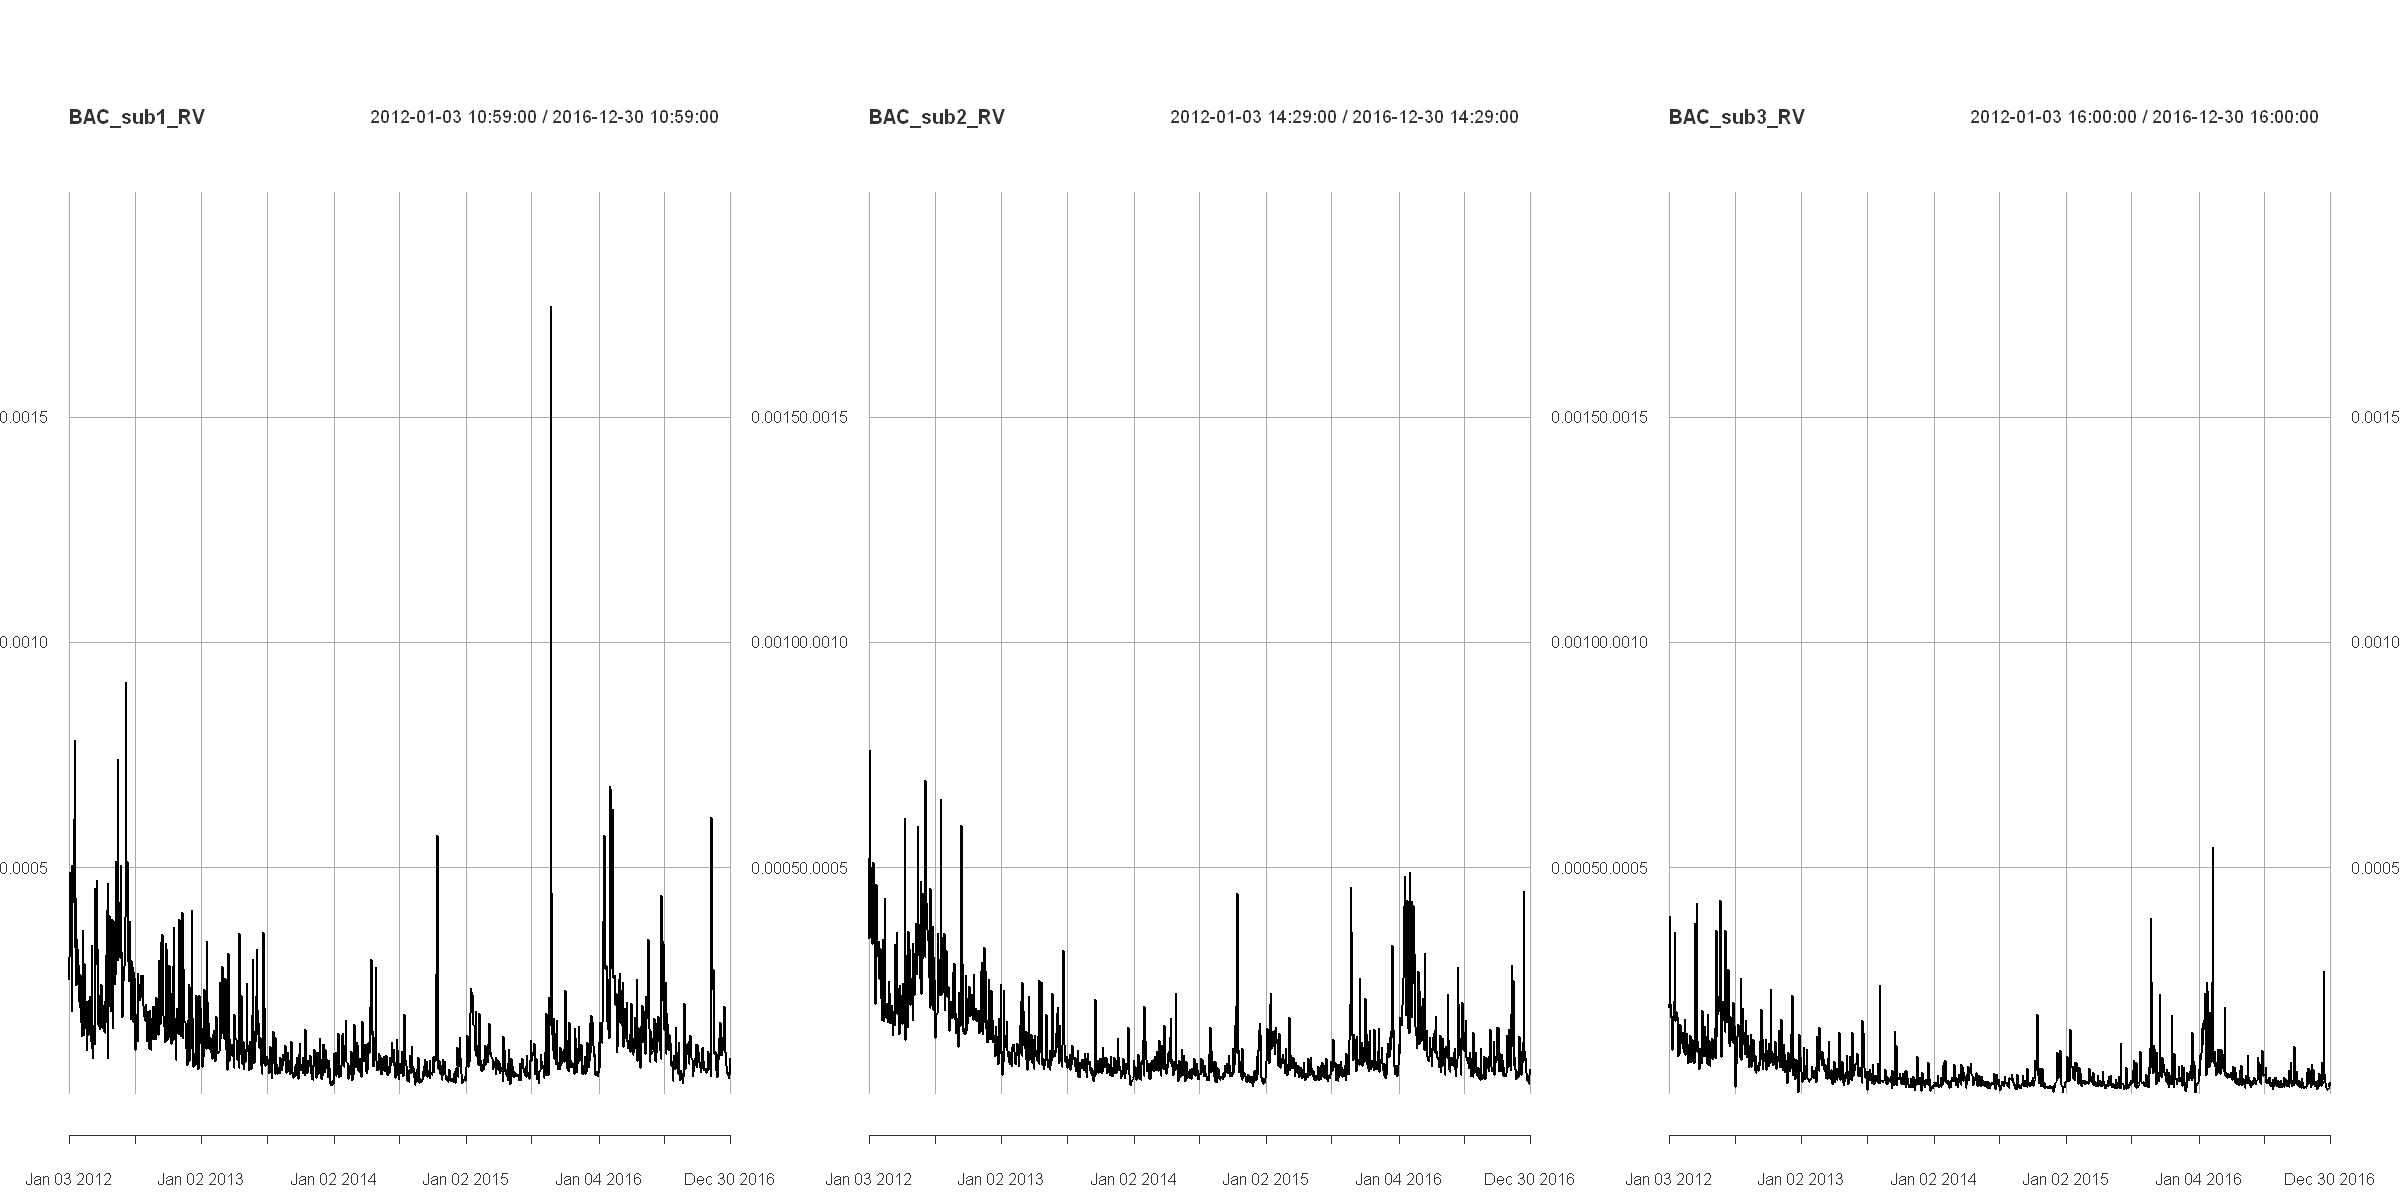

In [126]:
#plotting
options(repr.plot.width = 20, repr.plot.height = 10)
par(mfrow = c(1, 3))
y_lim <- 0.002 #set the range of y axis to the same value, use this parameter to make the changing easier
plot(BAC_sub1_RV, type = "l", ylim = c(0,y_lim))
plot(BAC_sub2_RV, type = "l", ylim = c(0,y_lim))
plot(BAC_sub3_RV, type = "l", ylim = c(0,y_lim))

#alternatively lines() could be used 

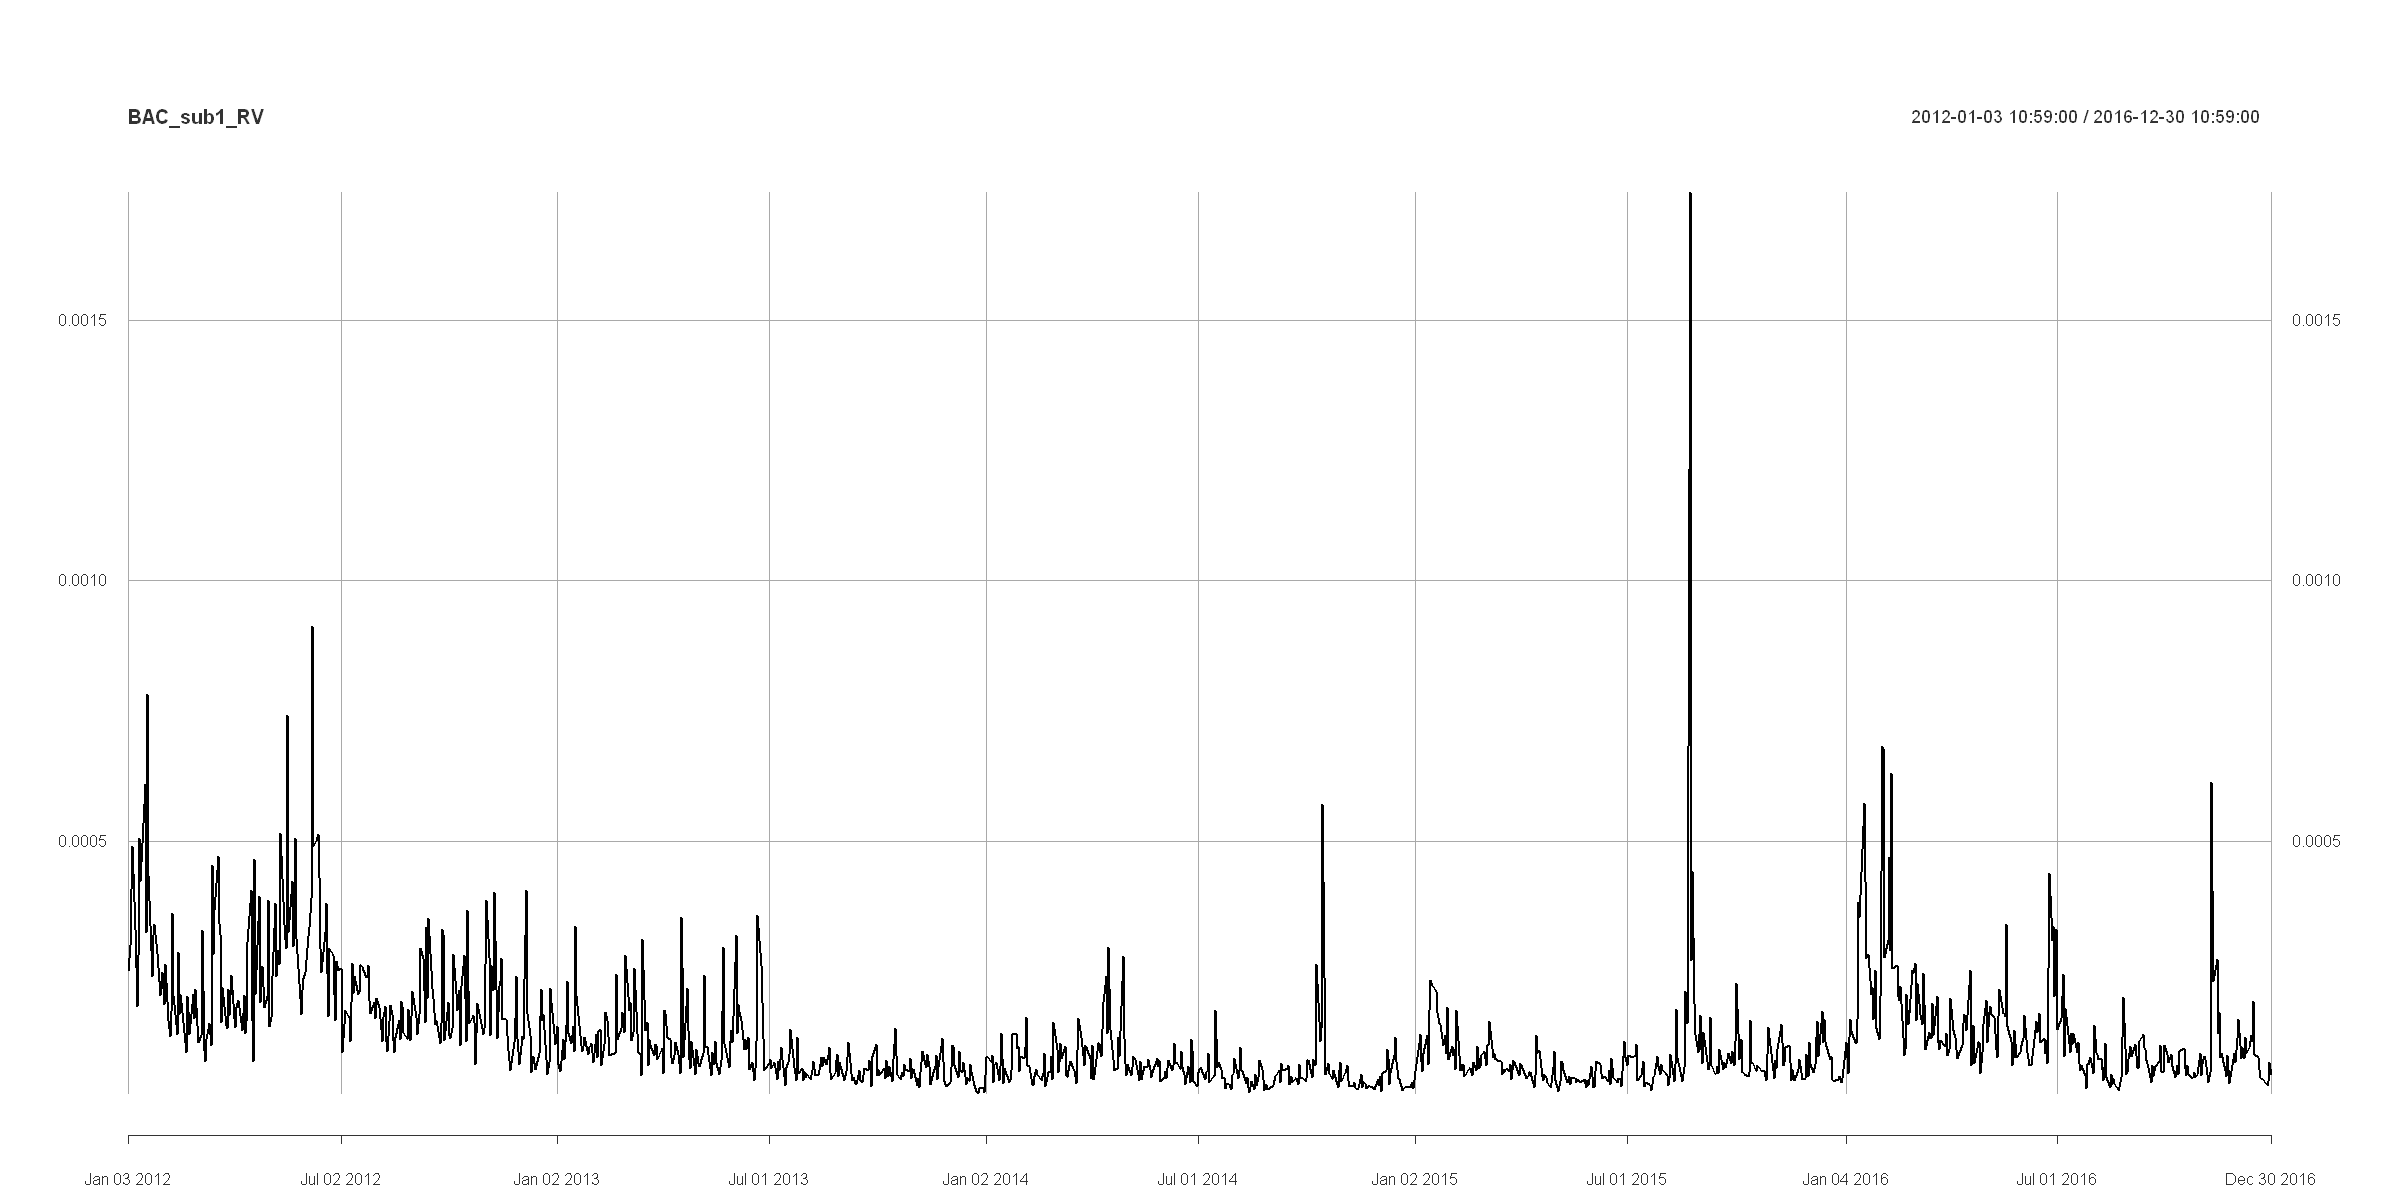

In [130]:
#plot <- plot(BAC_sub1_RV, type = "l")
#lns <- lines(BAC_sub2_RV, col = "blue")
#lines(BAC_sub3_RV, col = "red")


plot(BAC_sub1_RV, type = "l")
lines(BAC_sub2_RV,  col = "blue") #why lines() do not work? :(

---

In this task we split the previously calculated returns into the given periods and then compute the Realized Variance for each subset.

In [7]:
#Calculating Realized Variance for the sub-periods
real_var_subsets <- vector("list", 3) #Empty vector for the results
sub_periods <- c("T09:30/T10:59", "T11:00/T14:29", "T14:30/T16:00") #Saving the sub-periods to subset
for (i in 1:3) { #Looping through the tickers
    real_var_subsets_indiv <- vector("list", 3) #Empty list for the results for each ticker
    for (j in 1:3) { #Looping through the sub-periods
        real_var_subsets_indiv[[j]] <- rCov(na.omit(hw3_data_final[[i]][sub_periods[j]]), makeReturns = FALSE) #Calculating RV on the subset
    }
    real_var_subsets[[i]] <- real_var_subsets_indiv #Storing the results
}

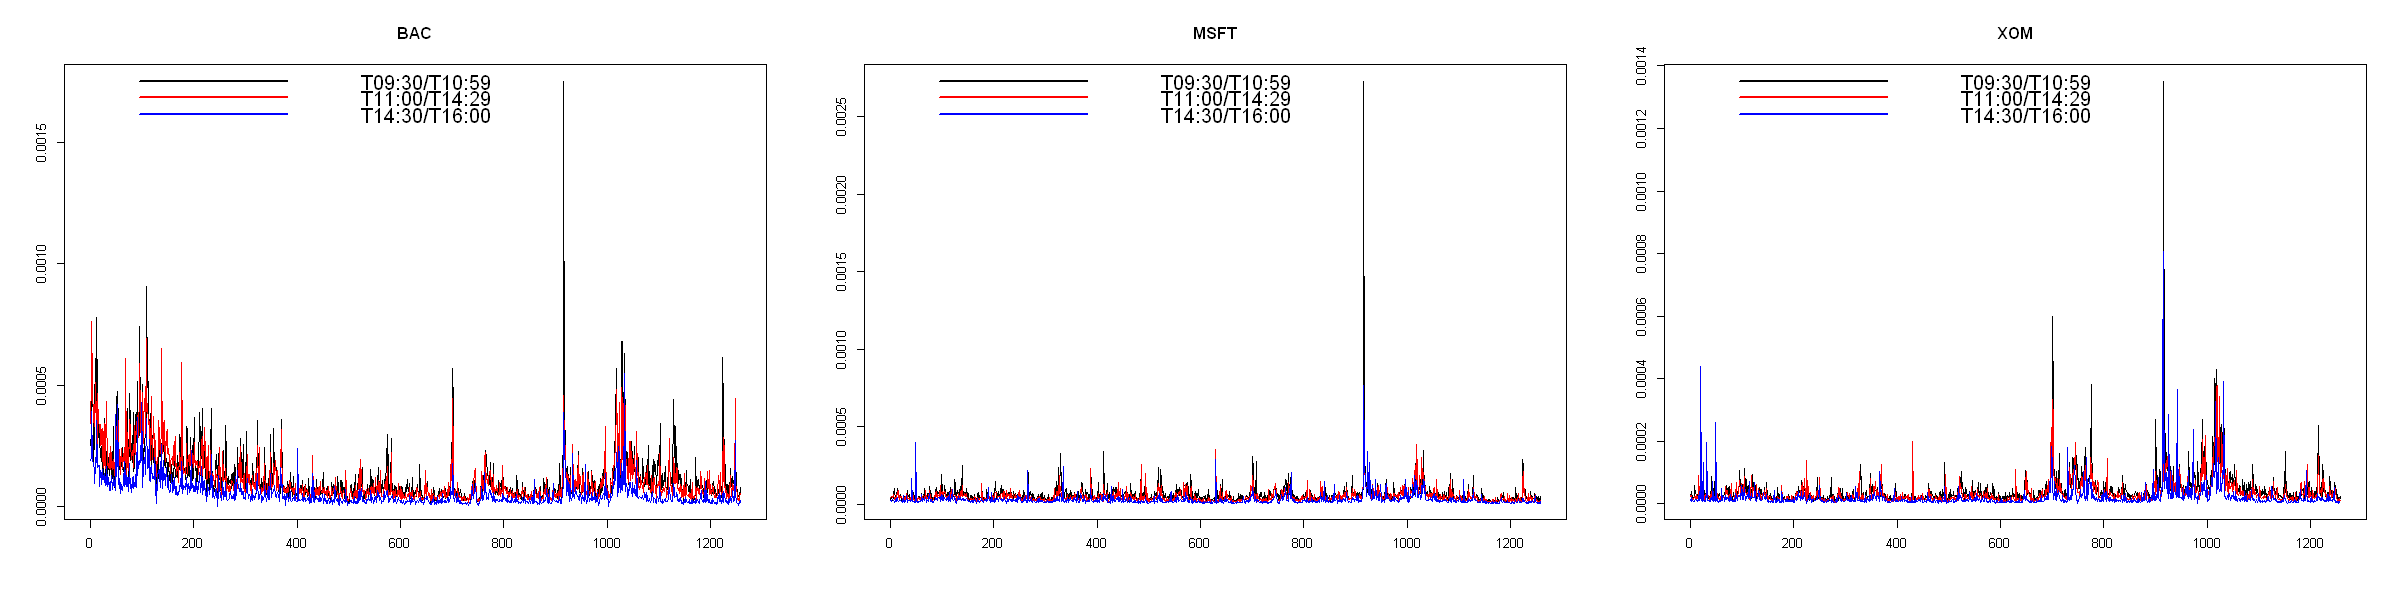

In [11]:
#Plotting
options(repr.plot.width = 20, repr.plot.height = 5)
par(mfrow = c(1, 3)) #Setting up the grid
for (i in 1:3) { #Looping through the tickers
    plot(as.numeric(real_var_subsets[[i]][[1]]), type = "l", xlab = "", ylab = "", main = stock_names[i])
    lines(as.numeric(real_var_subsets[[i]][[2]]), col = "red")
    lines(as.numeric(real_var_subsets[[i]][[3]]), col = "blue")
    legend("topleft", sub_periods, col = c("black", "red", "blue"), lty = 1, bty = "n", cex = 1.5, lwd = 2)
}


### 6.

Now, we simply sum the intraday returns for each day.

In [8]:
#Calculating the sum of intraday RV
sum_intraday_RV <- vector("list", 3) #Empty list for sums of intraday RV
for (i in 1:3) { #Looping through the tickers
    time_removed <- lapply(real_var_subsets[[i]], to.daily, OHLC = F) #Removing the time stamp from each subset for easier handling
    subsets_merged <- merge.xts(time_removed[[1]], time_removed[[2]], time_removed[[3]]) #Merging the subsets into a single xts object
    sum_intraday_RV[[i]] <- apply.daily(subsets_merged, sum) #Summing RV for each day
}
#Removing the time stamp from daily RV for easier plotting
daily_RV <- lapply(real_var_from_returns, to.daily, OHLC = F)

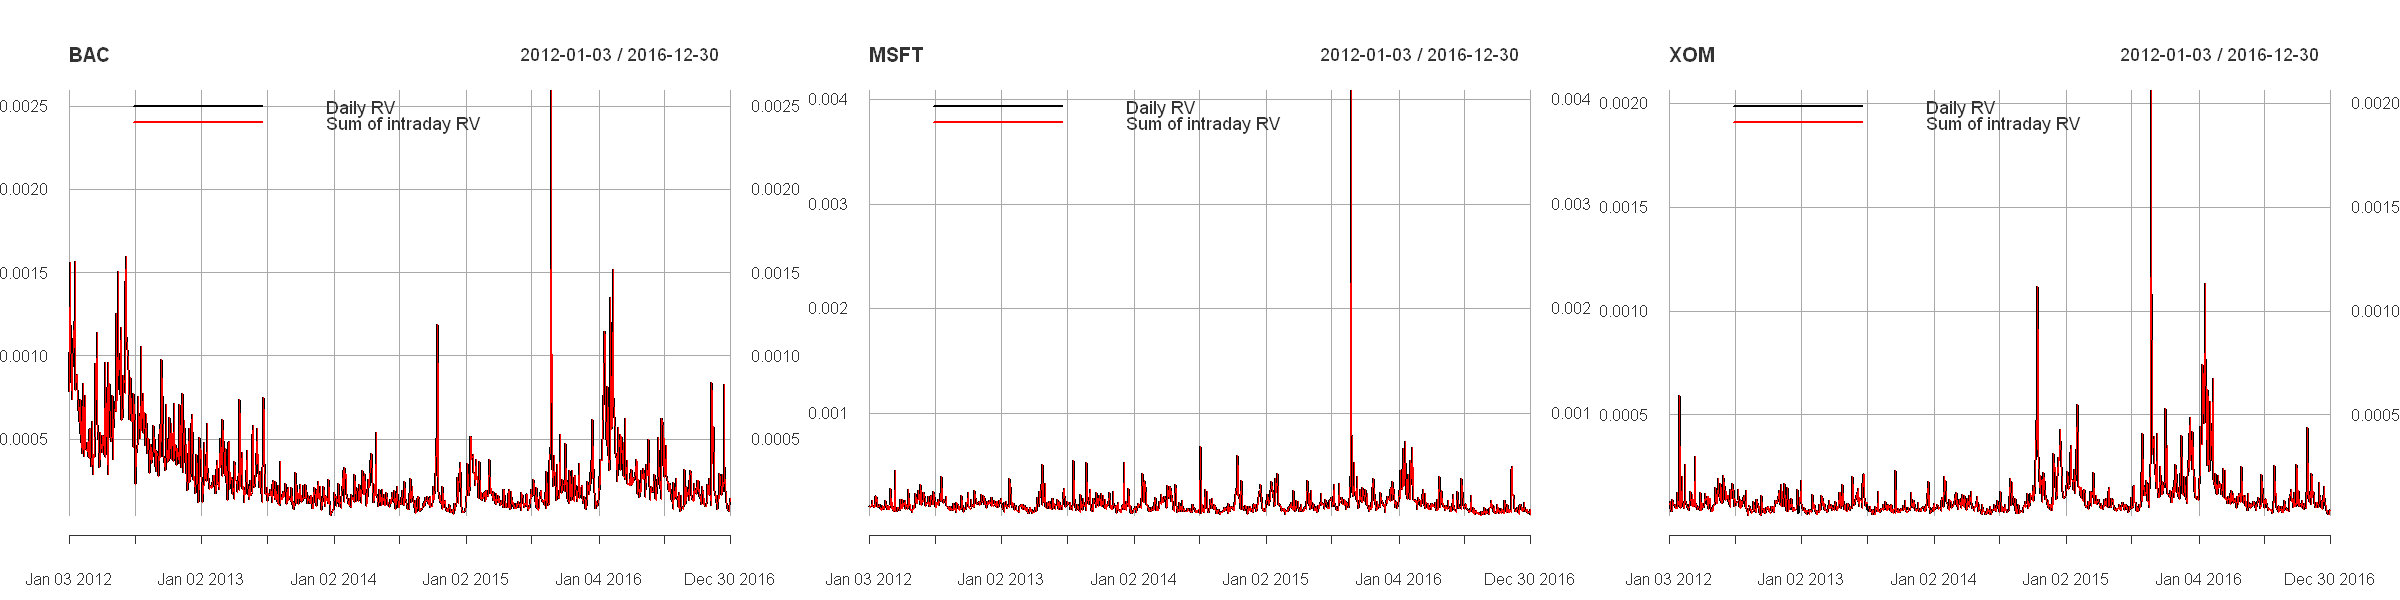

In [13]:
#Plotting
par(mfrow = c(1, 3)) #Setting up the grid
for (i in 1:3) { #Looping through the tickers
    plot_holder <- plot(daily_RV[[i]], main = stock_names[i])
    plot_holder <- lines(sum_intraday_RV[[i]], col = "red")
    plot_holder <- addLegend("topleft", on = 1, legend.names = c("Daily RV", "Sum of intraday RV"), col = c("black", "red"), lty = 1, bty = "n", lwd = 2)
    print(plot_holder)
}

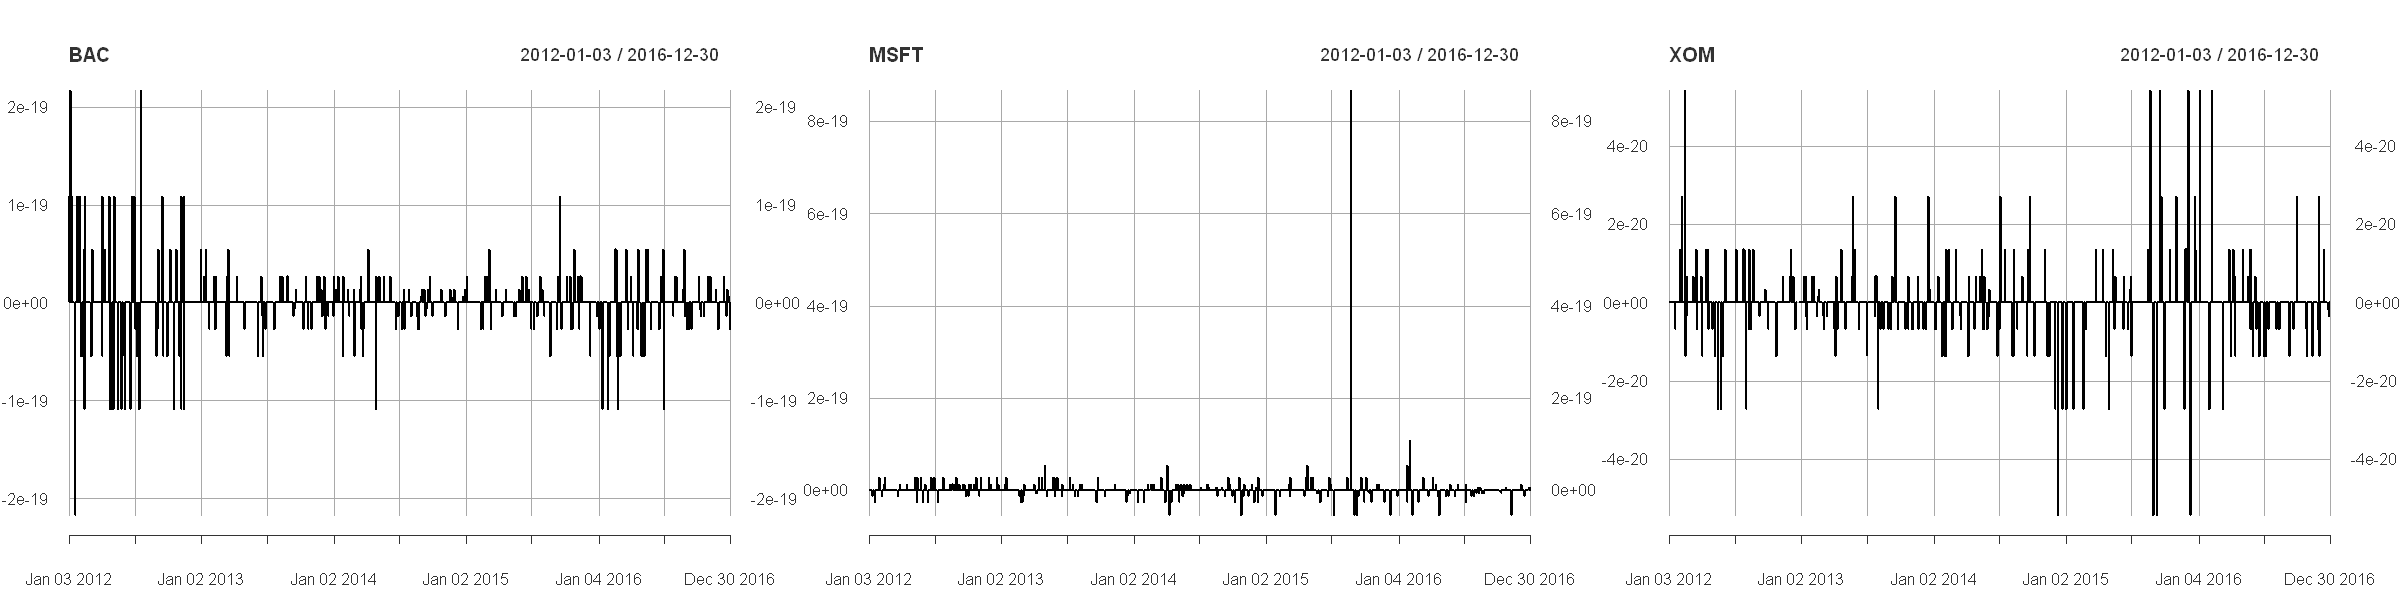

In [14]:
#Plotting the difference
par(mfrow = c(1, 3)) #Setting up the grid
for (i in 1:3) { #Looping through the tickers
    print(plot(daily_RV[[i]] - sum_intraday_RV[[i]], main = stock_names[i]))
}

### 7.

In [9]:
#Calculating the percentage share of each intrady RV in daily RV
percentage_shares <- vector("list", 3) #Empty vector for the results
for (i in 1:3) { #Looping through the tickers
    time_removed <- lapply(real_var_subsets[[i]], to.daily, OHLC = F) #Removing the time stamp from each subset for easier handling
    percentage_shares_list <- lapply(time_removed, function(x) {x / daily_RV[[i]]}) #Calculating the shares for each subset
    percentage_shares[[i]] <- merge.xts(percentage_shares_list[[1]], percentage_shares_list[[2]], percentage_shares_list[[3]]) #Merging the results into a single xts object (3 shares per day)
    names(percentage_shares[[i]]) <- sub_periods #Renaming the series for plotting
}

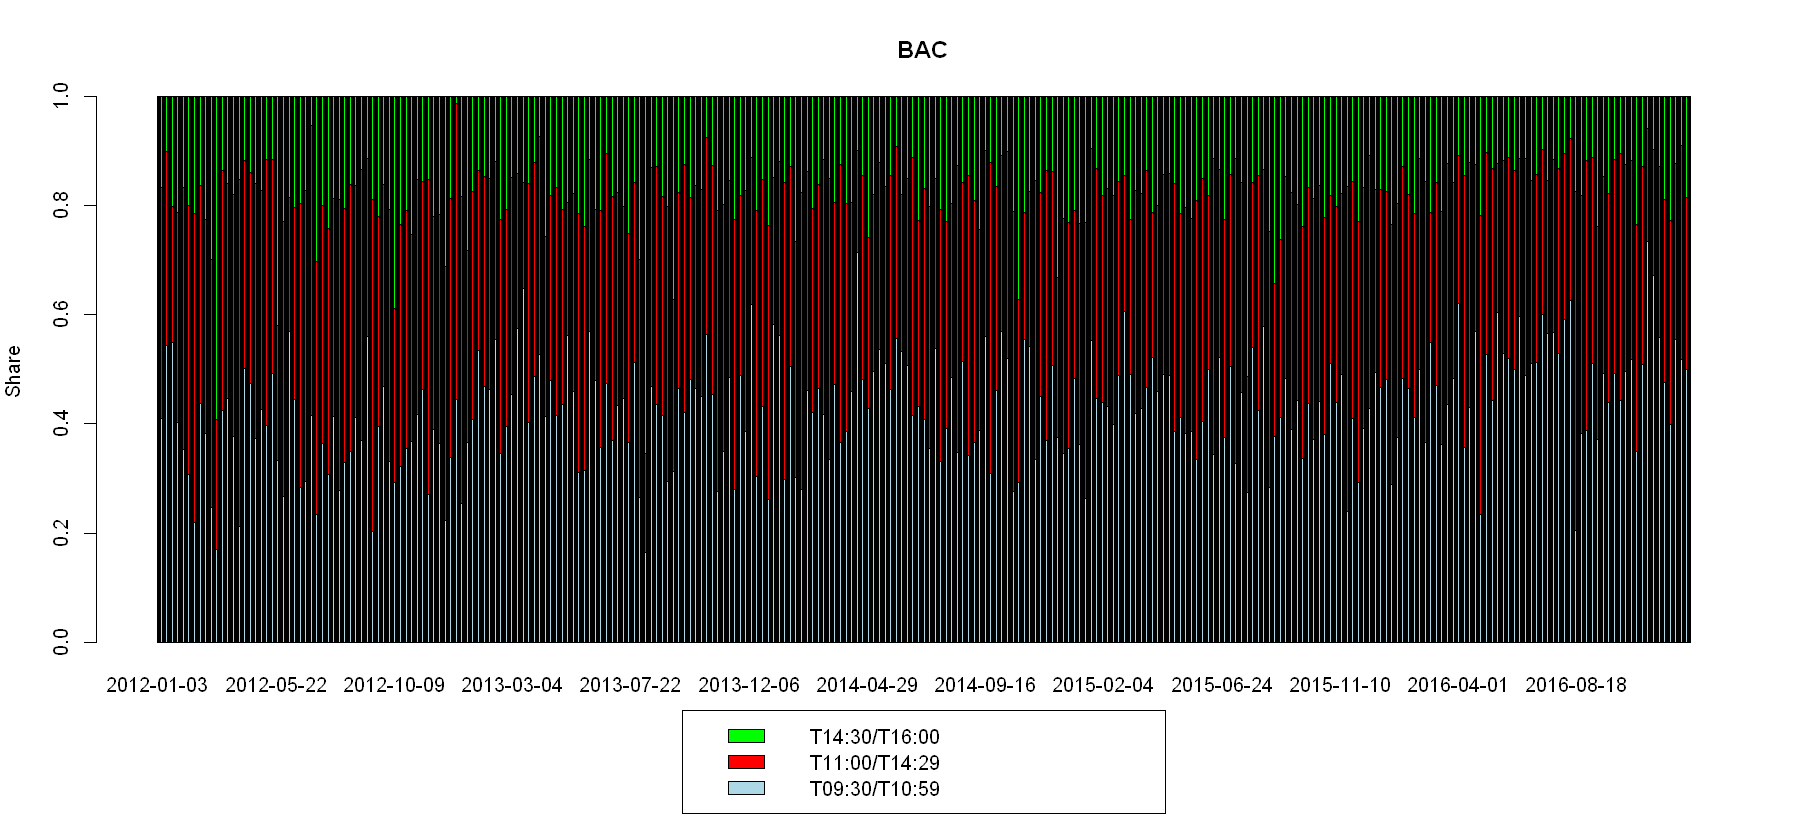

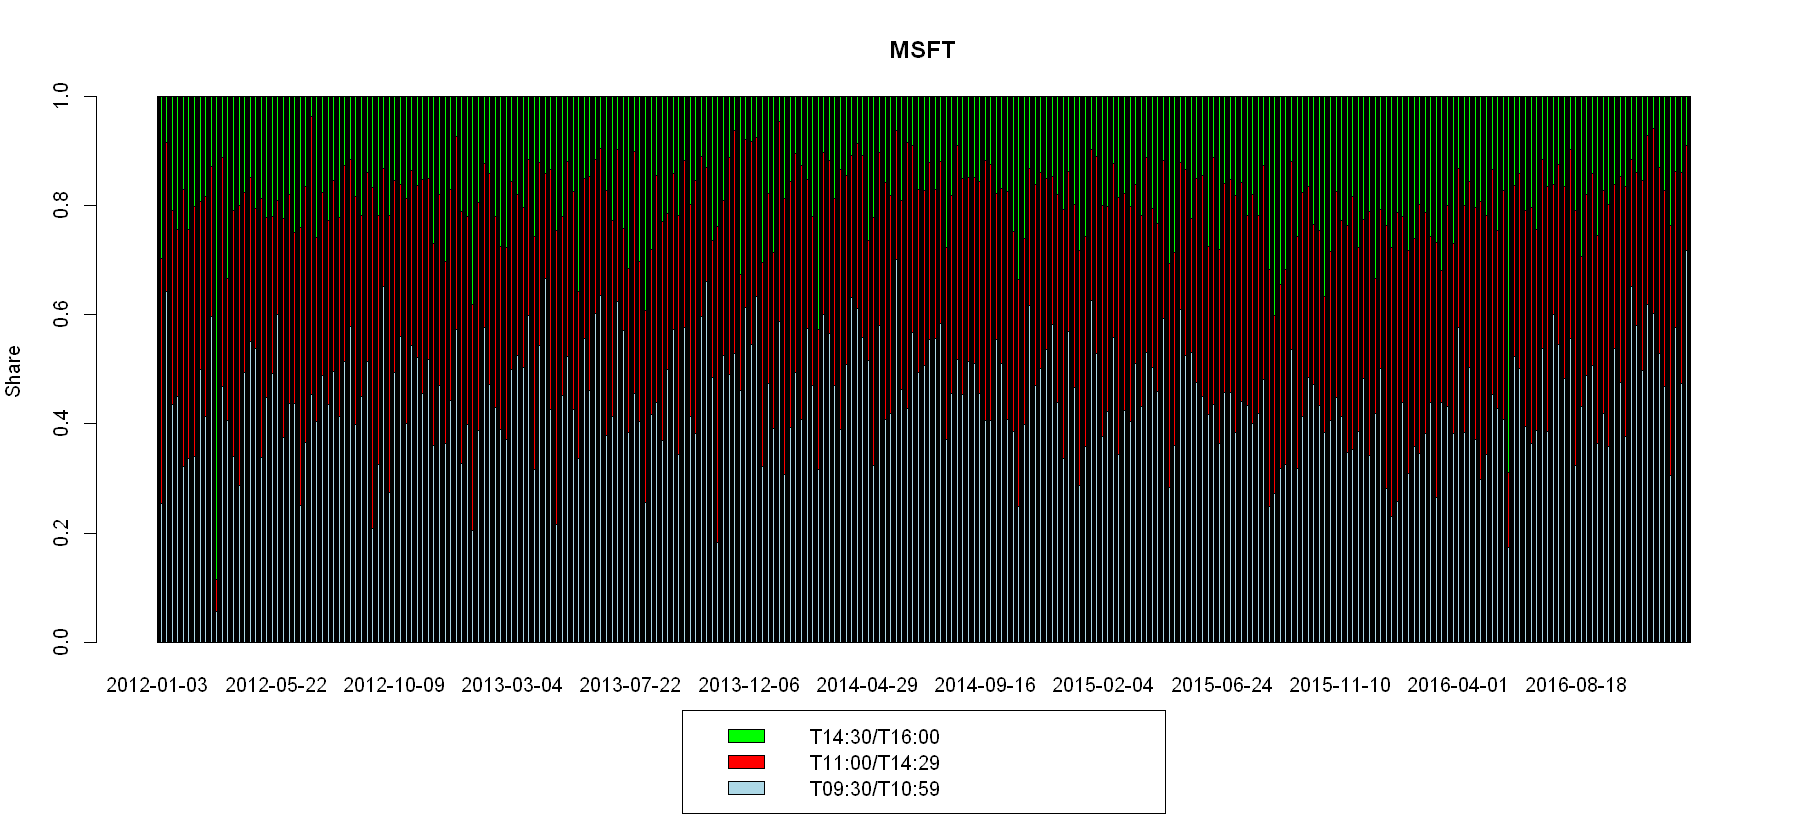

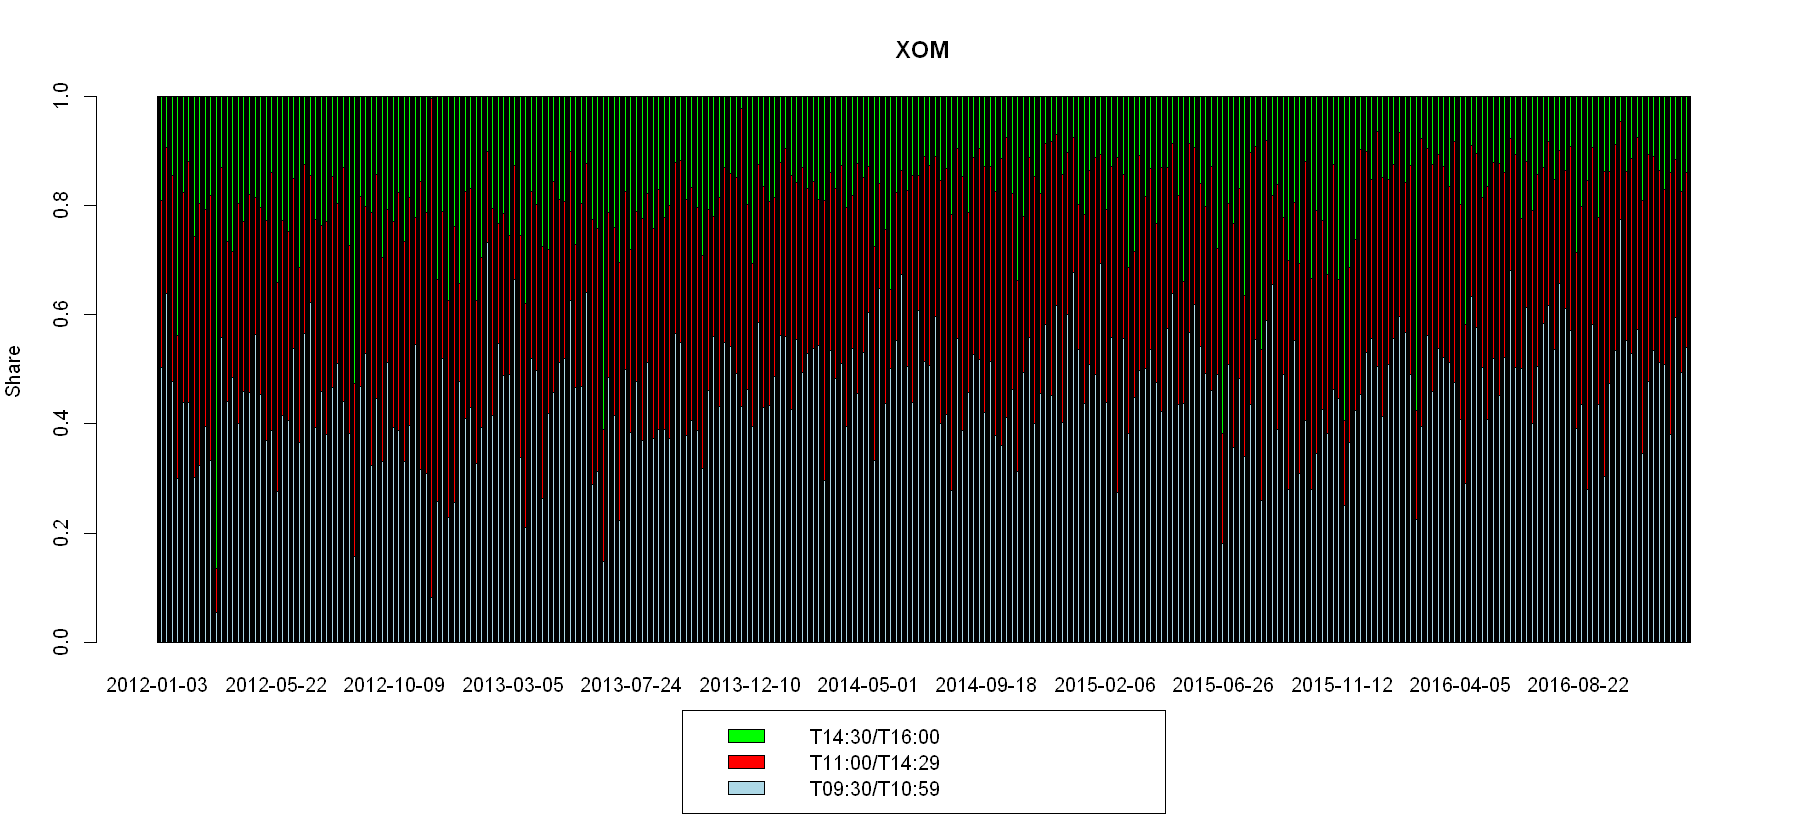

In [16]:
#Plotting
options(repr.plot.width = 15, repr.plot.height = 7)
par(mar = c(8, 4, 4, 2)) #Making a space for the legend
for (i in 1:3) {
    barplot(na.omit(percentage_shares[[i]]), col = c("lightblue", "red", "green"), space = 0, main = stock_names[i], ylab = "Share", legend = T, args.legend = list(x = "bottom", inset = -0.3)) #Omitting 2 NAs that emerged in XOM after merging
}

### 8.

In [10]:
#Firstly, we check that for each day in each sub-period for each ticker we have at least 2 observations
#If there is only a single observation in a day, we remove it since the rCov function with makeReturns = TRUE cannot handle it
for (i in 1:3) { #Looping through the tickers
    for (j in 1:3) { #Looping throught the sub-periods
        days_holder <- split(hw3_data_restricted[[i]][sub_periods[j]], "days") #Splitting the sub-periods by days 
        for (k in days_holder) { #For each day
            if (length(k) == 1) { #If there is only a single day
                index_to_remove <- which(index(hw3_data_restricted[[i]]) == as.POSIXct(index(k), tz = "UTC")) #Extract the index to remove
                hw3_data_restricted[[i]] <- hw3_data_restricted[[i]][-index_to_remove] #Remove the specific observation
                print(paste("Removed observation", index(k), "from sub-period", sub_periods[j], "from ticker", stock_names[i])) #Print what was removed
            }
        }
    }
}

[1] "Removed observation 2013-11-29 15:56:00 from sub-period T14:30/T16:00 from ticker MSFT"
[1] "Removed observation 2015-12-24 14:49:00 from sub-period T14:30/T16:00 from ticker MSFT"


In [11]:
#Calculating Realized Variance for the sub-periods
real_var_subsets_from_prices <- vector("list", 3) #Empty vector for the results
for (i in 1:3) { #Looping through the tickers
    real_var_subsets_from_prices_indiv <- vector("list", 3) #Empty list for the results for each ticker
    for (j in 1:3) { #Looping through the sub-periods
        real_var_subsets_from_prices_indiv[[j]] <- rCov(hw3_data_restricted[[i]][sub_periods[j]], makeReturns = TRUE) #Calculating RV on the subset
    }
    real_var_subsets_from_prices[[i]] <- real_var_subsets_from_prices_indiv #Storing the results
}

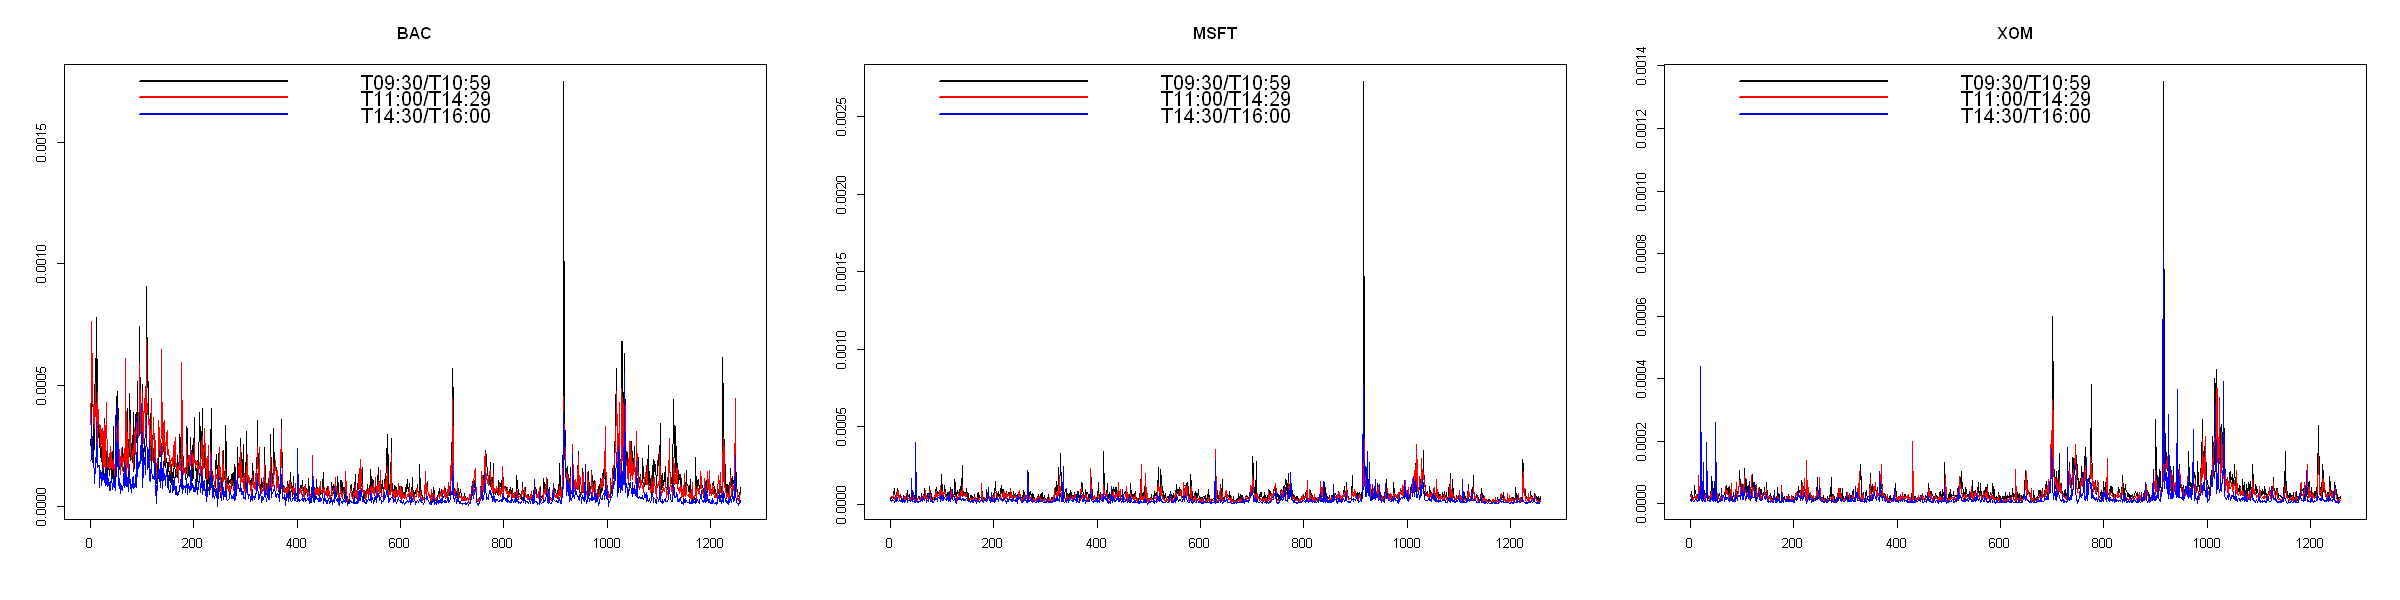

In [53]:
#Plotting
options(repr.plot.width = 20, repr.plot.height = 5)
par(mfrow = c(1, 3)) #Setting up the grid
for (i in 1:3) { #Looping through the tickers
    plot(as.numeric(real_var_subsets_from_prices[[i]][[1]]), type = "l", xlab = "", ylab = "", main = stock_names[i])
    lines(as.numeric(real_var_subsets_from_prices[[i]][[2]]), col = "red")
    lines(as.numeric(real_var_subsets_from_prices[[i]][[3]]), col = "blue")
    legend("topleft", sub_periods, col = c("black", "red", "blue"), lty = 1, bty = "n", cex = 1.5, lwd = 2)
}

In [12]:
#Calculating the sum of intraday RV from prices
sum_intraday_RV_from_prices <- vector("list", 3) #Empty list for sums of intraday RV
for (i in 1:3) { #Looping through the tickers
    time_removed <- lapply(real_var_subsets_from_prices[[i]], to.daily, OHLC = F) #Removing the time stamp from each subset for easier handling
    subsets_merged <- merge.xts(time_removed[[1]], time_removed[[2]], time_removed[[3]]) #Merging the subsets into a single xts object
    sum_intraday_RV_from_prices[[i]] <- apply.daily(subsets_merged, sum) #Summing RV for each day
}
#Removing the time stamp from daily RV for easier plotting
daily_RV_from_prices <- lapply(real_var_from_prices, to.daily, OHLC = F)

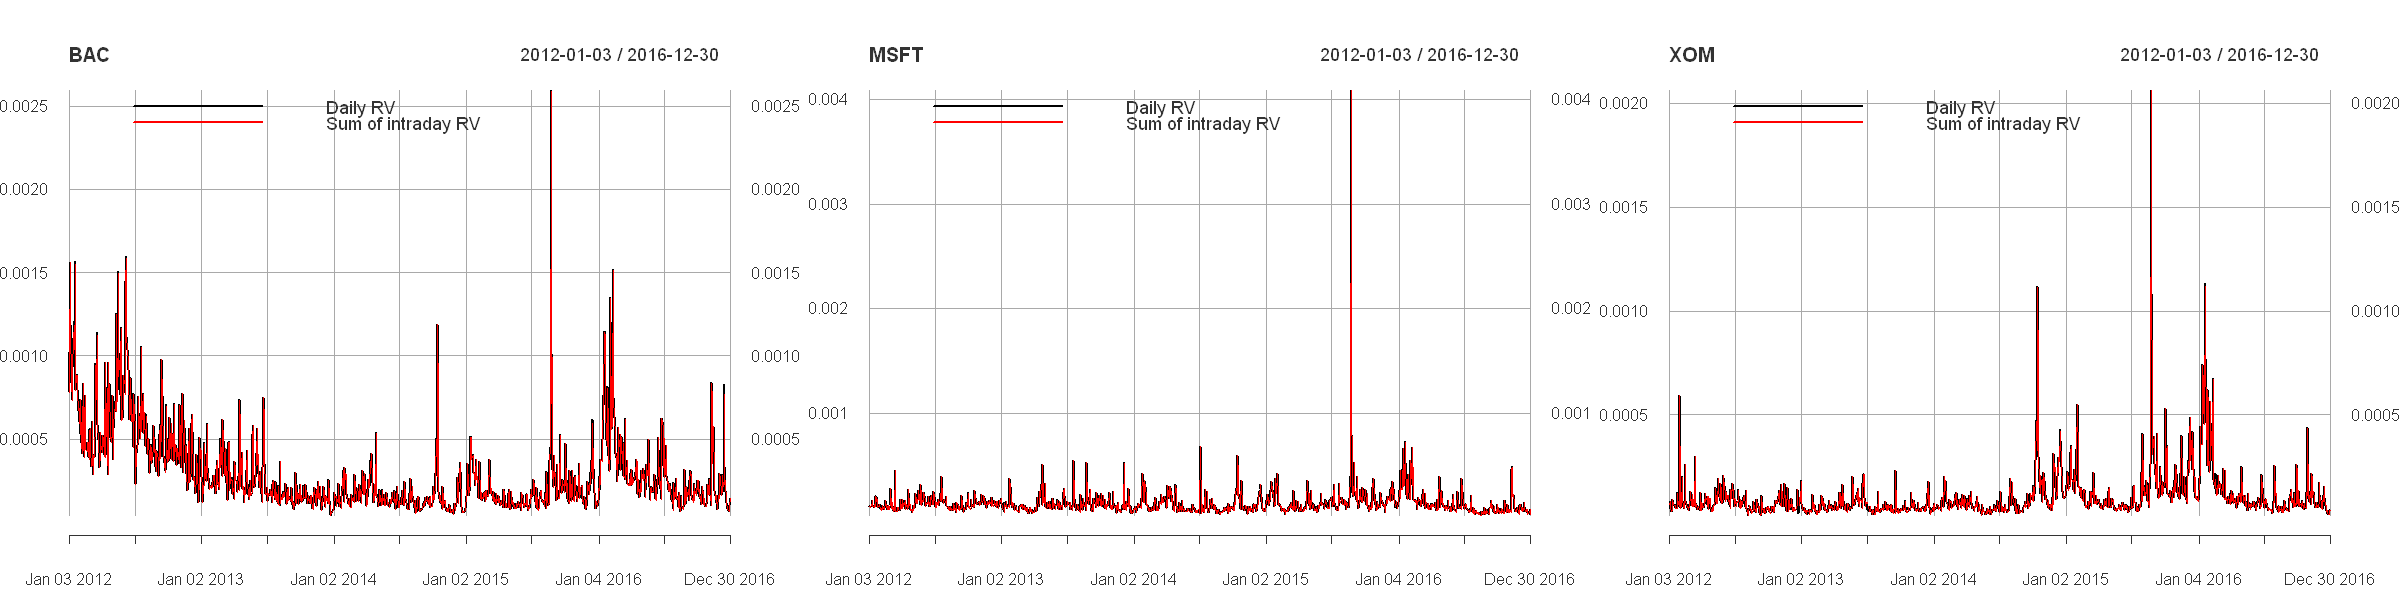

In [55]:
#Plotting
par(mfrow = c(1, 3)) #Setting up the grid
for (i in 1:3) { #Looping through the tickers
    plot_holder <- plot(daily_RV_from_prices[[i]], main = stock_names[i])
    plot_holder <- lines(sum_intraday_RV_from_prices[[i]], col = "red")
    plot_holder <- addLegend("topleft", on = 1, legend.names = c("Daily RV", "Sum of intraday RV"), col = c("black", "red"), lty = 1, bty = "n", lwd = 2)
    print(plot_holder)
}

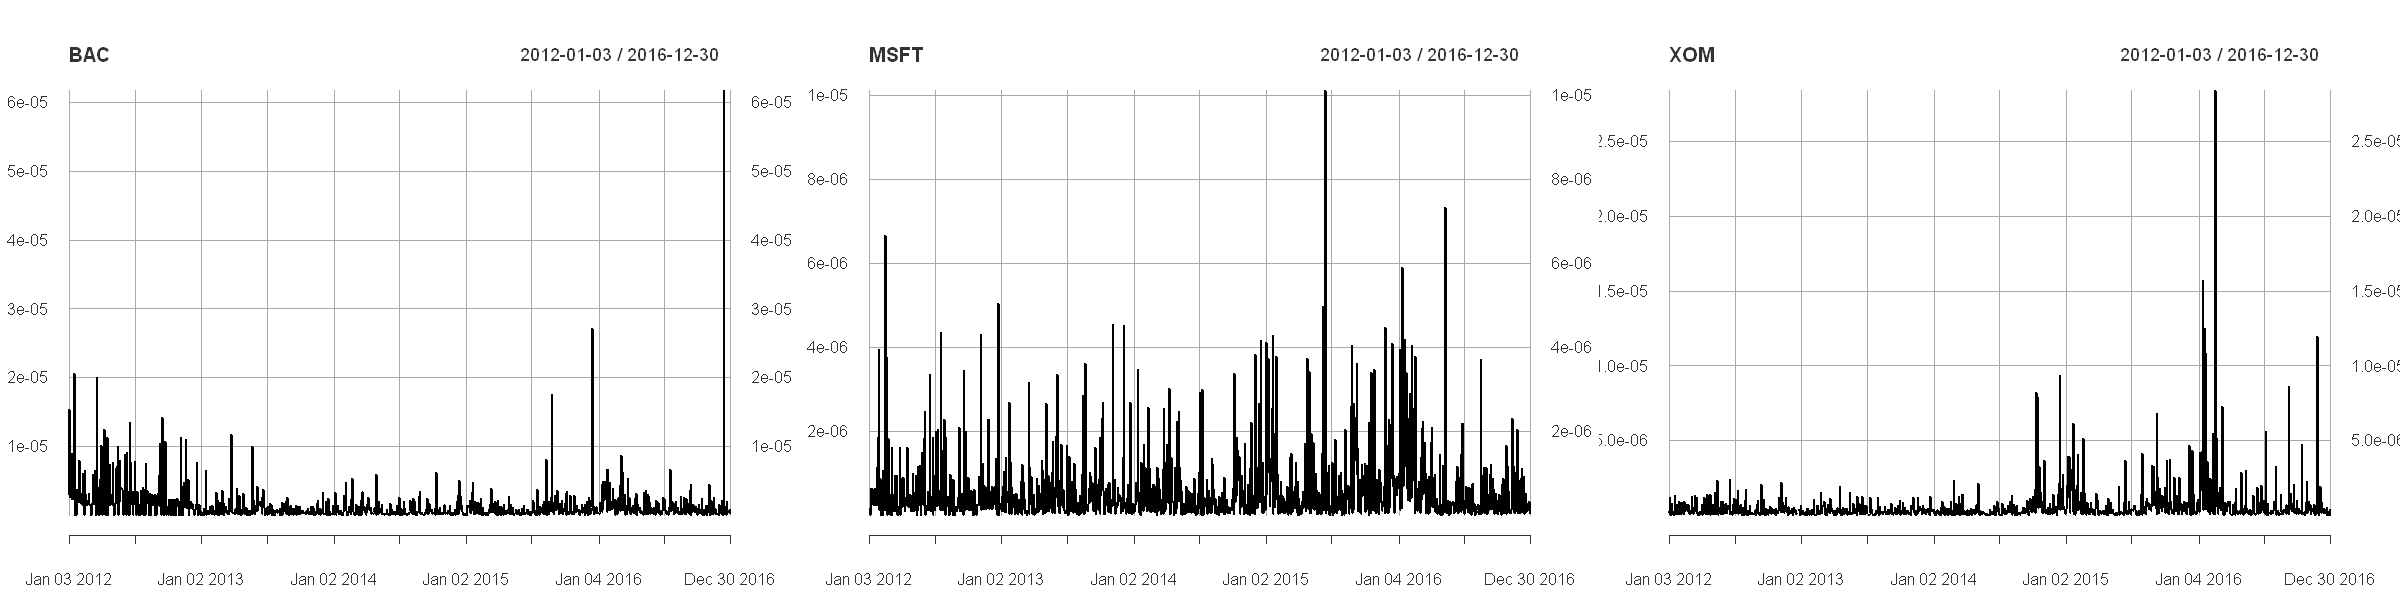

In [56]:
#Plotting the difference
par(mfrow = c(1, 3)) #Setting up the grid
for (i in 1:3) { #Looping through the tickers
    print(plot(daily_RV_from_prices[[i]] - sum_intraday_RV_from_prices[[i]], main = stock_names[i]))
}

In [13]:
#Calculating the percentage share of each intrady RV in daily RV from prices
percentage_shares_from_prices <- vector("list", 3) #Empty vector for the results
for (i in 1:3) { #Looping through the tickers
    time_removed <- lapply(real_var_subsets_from_prices[[i]], to.daily, OHLC = F) #Removing the time stamp from each subset for easier handling
    percentage_shares_list <- lapply(time_removed, function(x) {x / daily_RV_from_prices[[i]]}) #Calculating the shares for each subset
    percentage_shares_from_prices[[i]] <- merge.xts(percentage_shares_list[[1]], percentage_shares_list[[2]], percentage_shares_list[[3]]) #Merging the results into a single xts object (3 shares per day)
    names(percentage_shares_from_prices[[i]]) <- sub_periods #Renaming the series for plotting
}

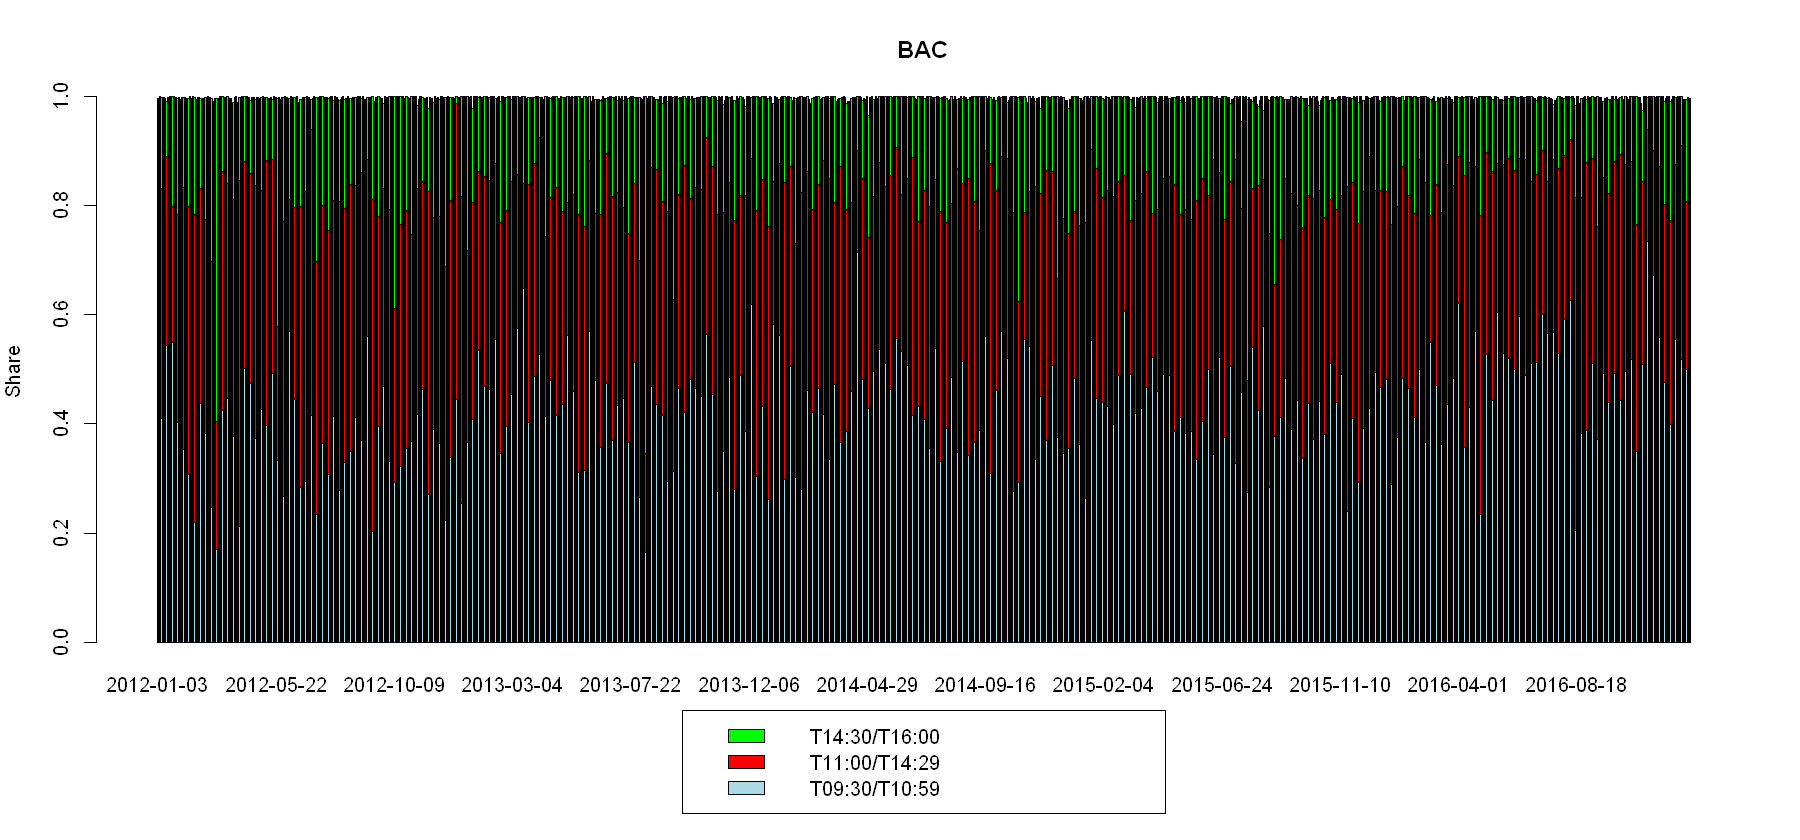

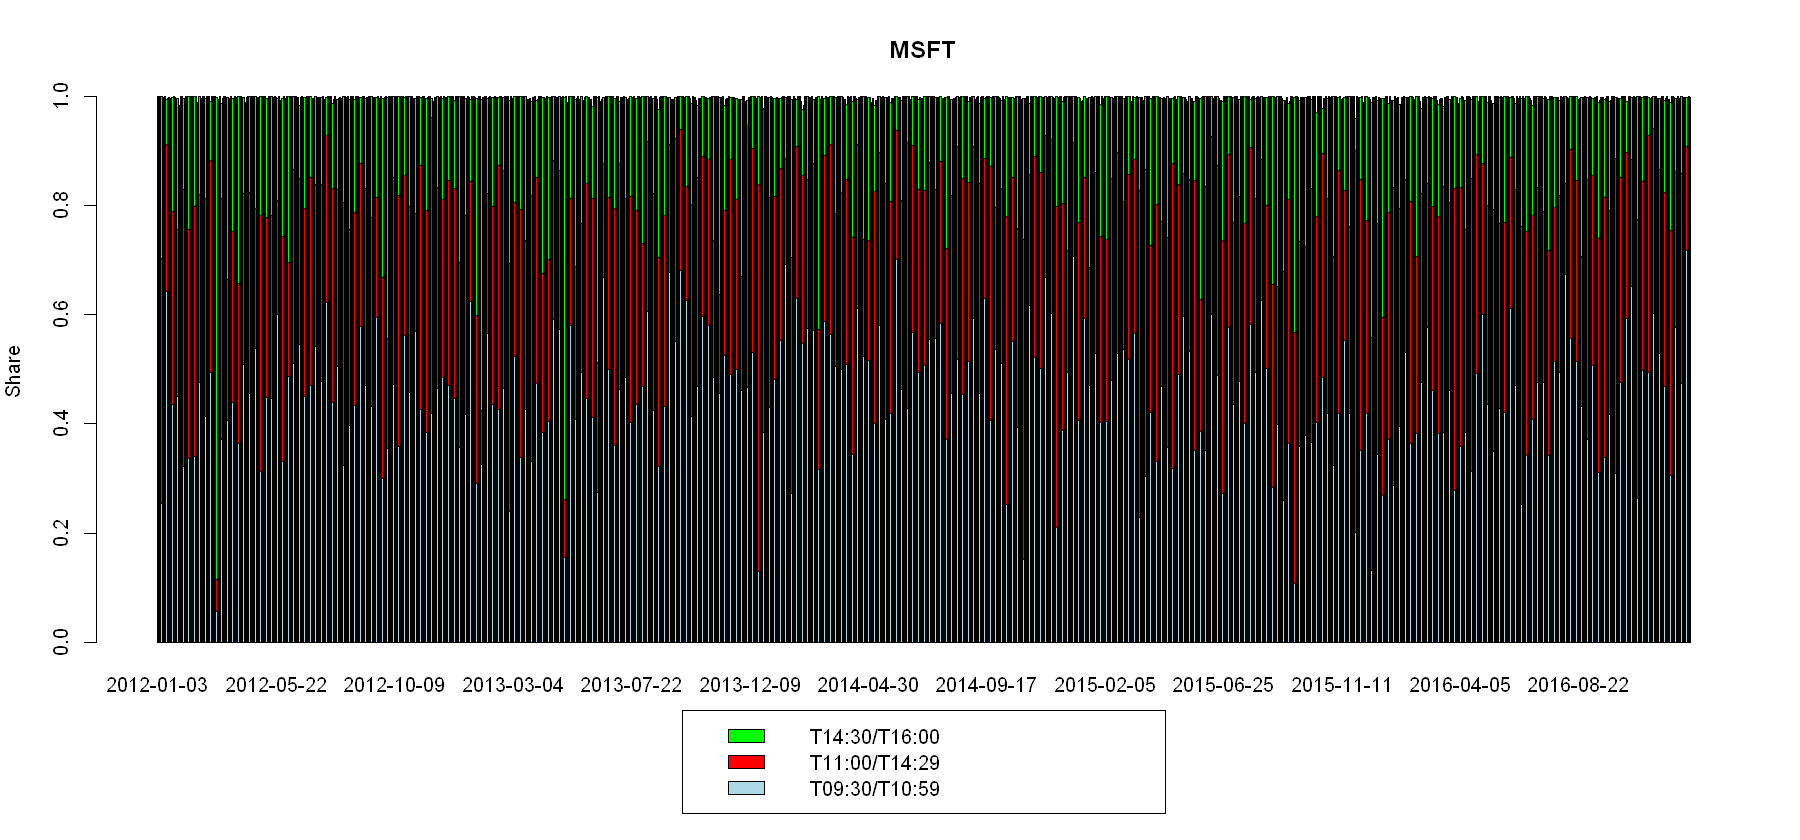

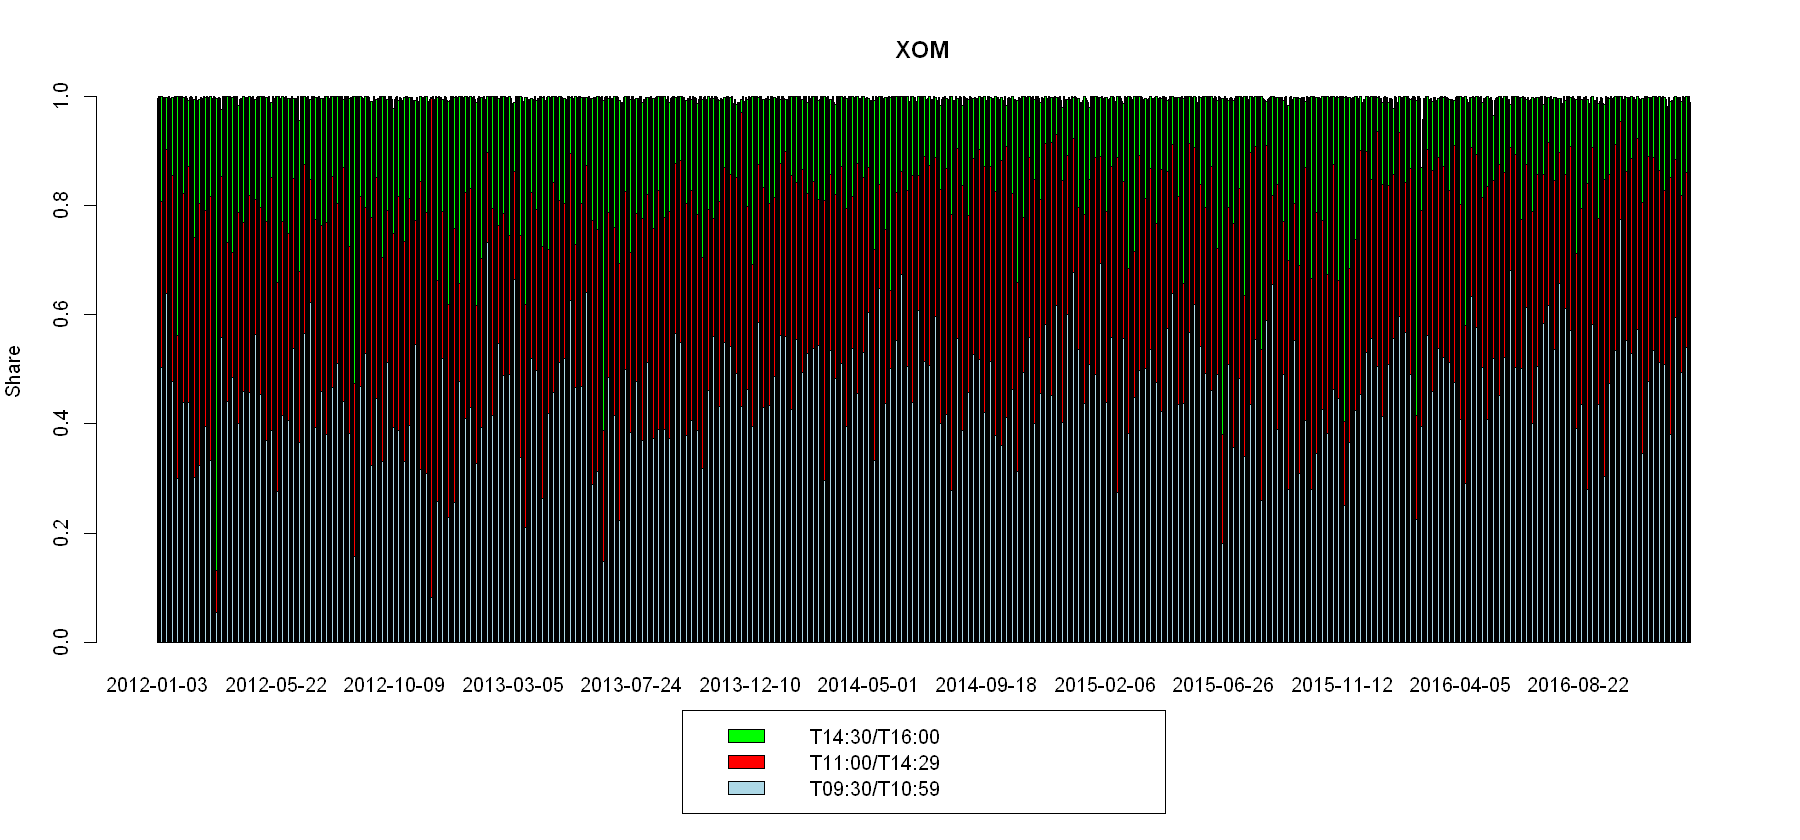

In [58]:
#Plotting
options(repr.plot.width = 15, repr.plot.height = 7)
par(mar = c(8, 4, 4, 2)) #Making a space for the legend
for (i in 1:3) {
    barplot(na.omit(percentage_shares_from_prices[[i]]), col = c("lightblue", "red", "green"), space = 0, main = stock_names[i], ylab = "Share", legend = T, args.legend = list(x = "bottom", inset = -0.3)) #Omitting 2 NAs that emerged in XOM after merging
}

### 9.

In [14]:
#Calculating Bipower Variation from prices
bpv <- vector("list", 3)
for (i in 1:3) {
    bpv[[i]] <- rBPCov(hw3_data_restricted[[i]], makeReturns = T)
}

In [15]:
#Calculating MedRV from prices
medrv <- vector("list", 3)
for (i in 1:3) {
    medrv[[i]] <- rMedRVar(hw3_data_restricted[[i]], makeReturns = T)
}

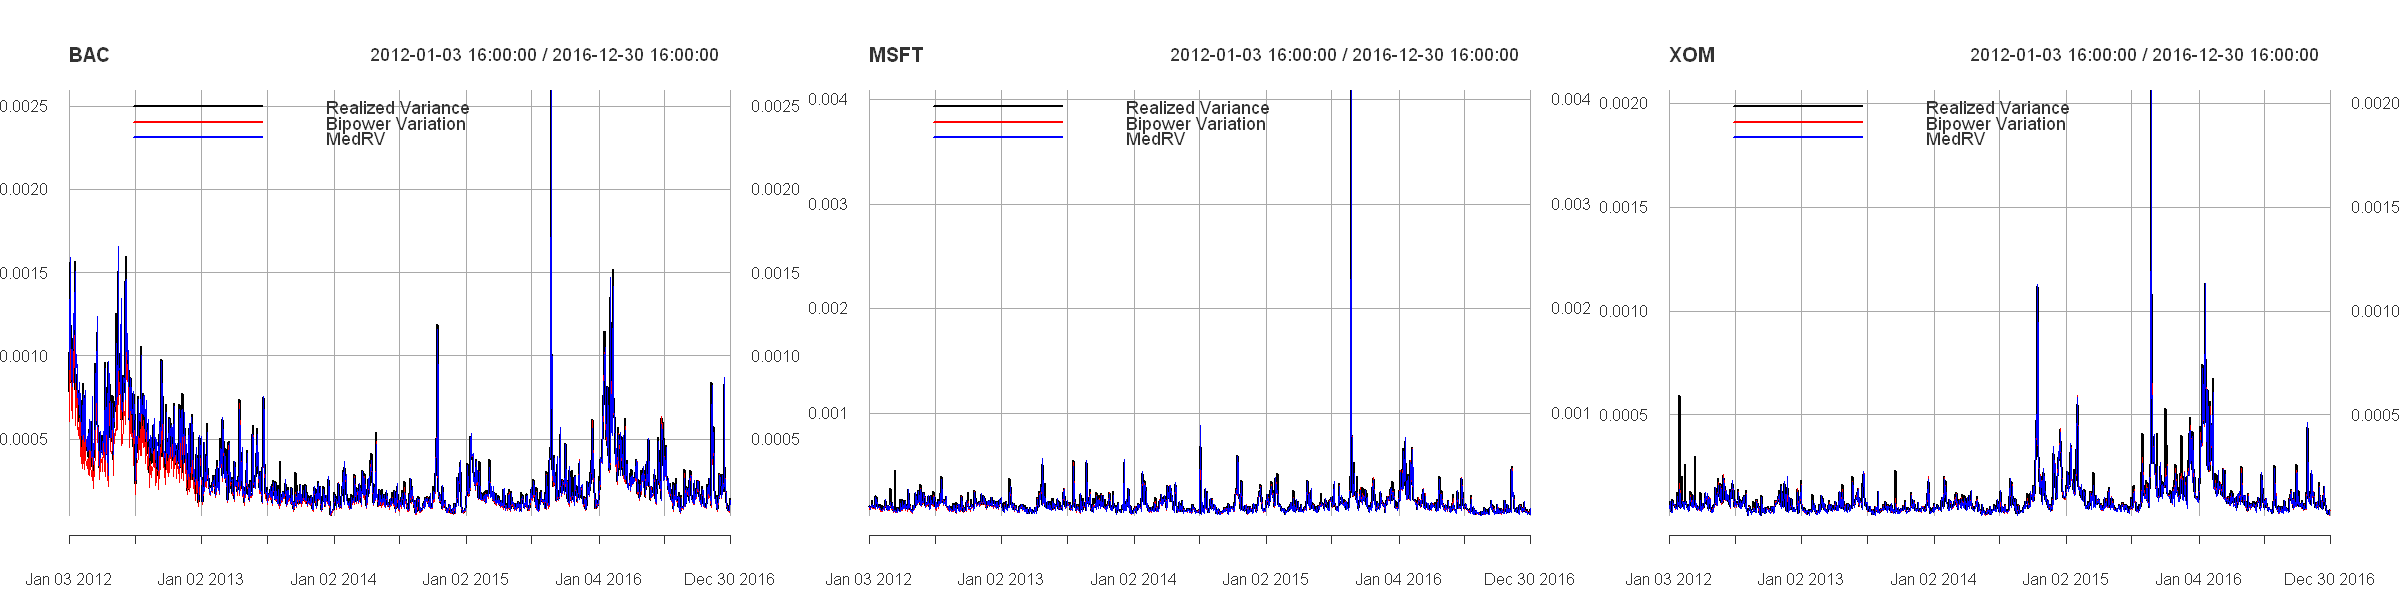

In [18]:
#Plotting the comparison of RV, BPV, MedRv
options(repr.plot.width = 20, repr.plot.height = 5)
par(mfrow = c(1, 3))
for (i in 1:3) { #Looping through the tickers
    plot_holder <- plot(real_var_from_prices[[i]], main = stock_names[i])
    plot_holder <- lines(bpv[[i]], col = "red")
    plot_holder <- lines(medrv[[i]], col = "blue")
    plot_holder <- addLegend("topleft", on = 1, legend.names = c("Realized Variance", "Bipower Variation", "MedRV"), col = c("black", "red", "blue"), lty = 1, bty = "n", lwd = 2)
    print(plot_holder)
}

In [16]:
#Calculating the jumps
jumps <- vector("list", 3)
for (i in 1:3) {
    jumps[[i]] <- real_var_from_prices[[i]] - bpv[[i]]
}

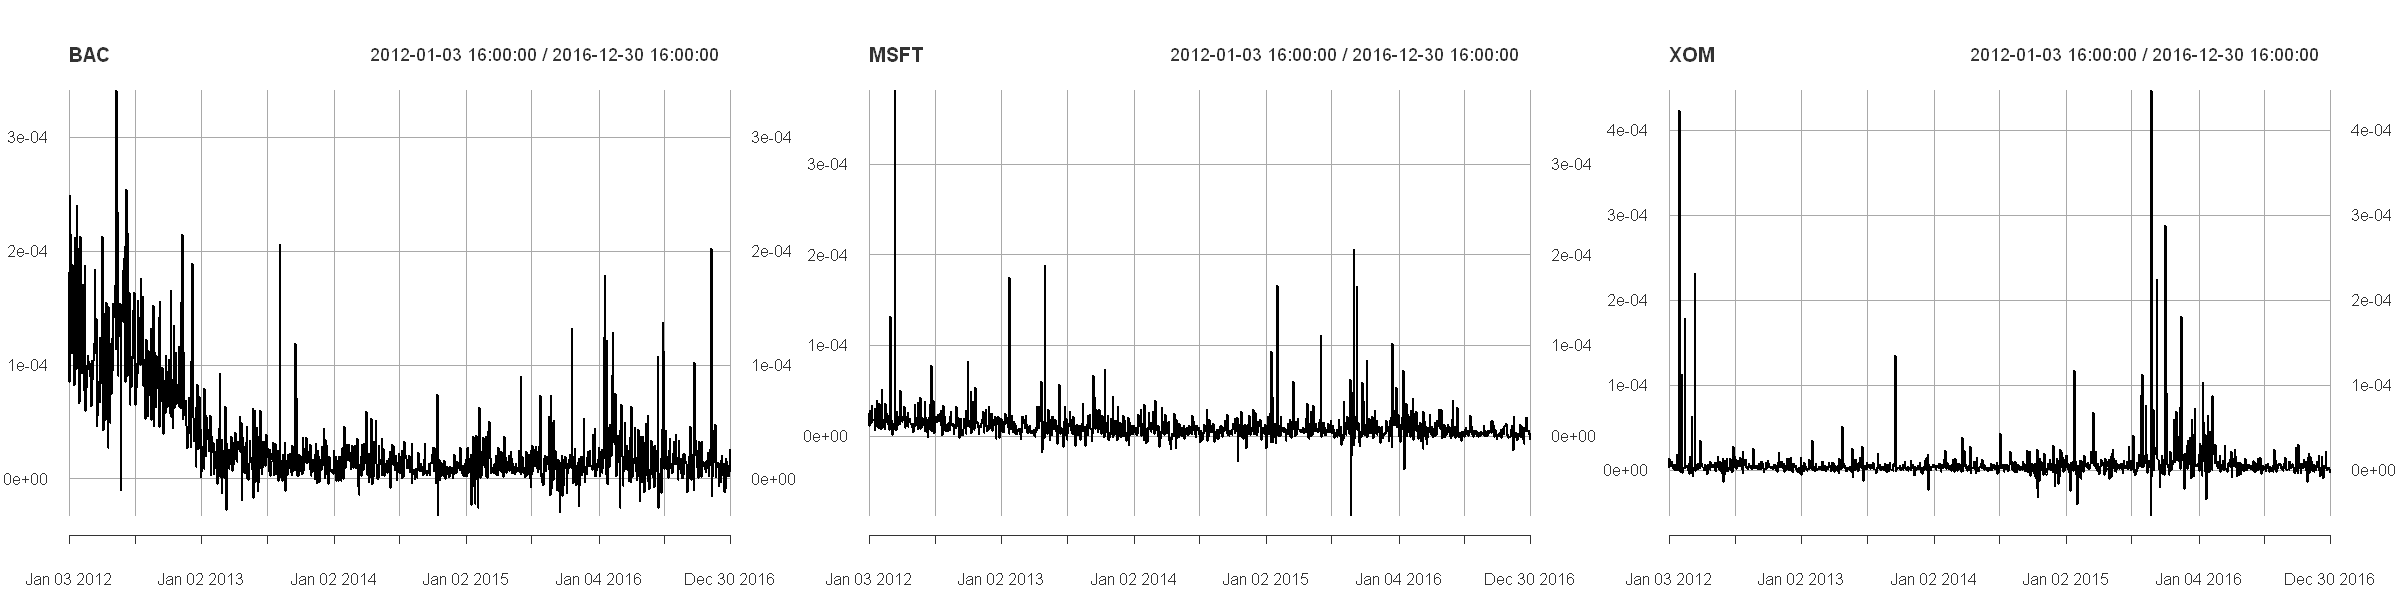

In [24]:
#Plotting the jumps
par(mfrow = c(1, 3))
for (i in 1:3) {
    print(plot(jumps[[i]], main = stock_names[i]))
}

In [17]:
#Testing jump significance and retaining only significant jumps
jumps_signif <- vector("list", 3)
for (i in 1:3) {
    jump_test <- BNSjumpTest(hw3_data_restricted[[i]], IVestimator = "BV", IQestimator = "TP", makeReturns = T) #Temporarily storing the results of the jump test
    jumps_signif[[i]] <- jumps[[i]] * ifelse(jump_test[, "p.value"] <= 0.05, 1, 0) #Keeping only singificant jumps (95% conf. level)
}

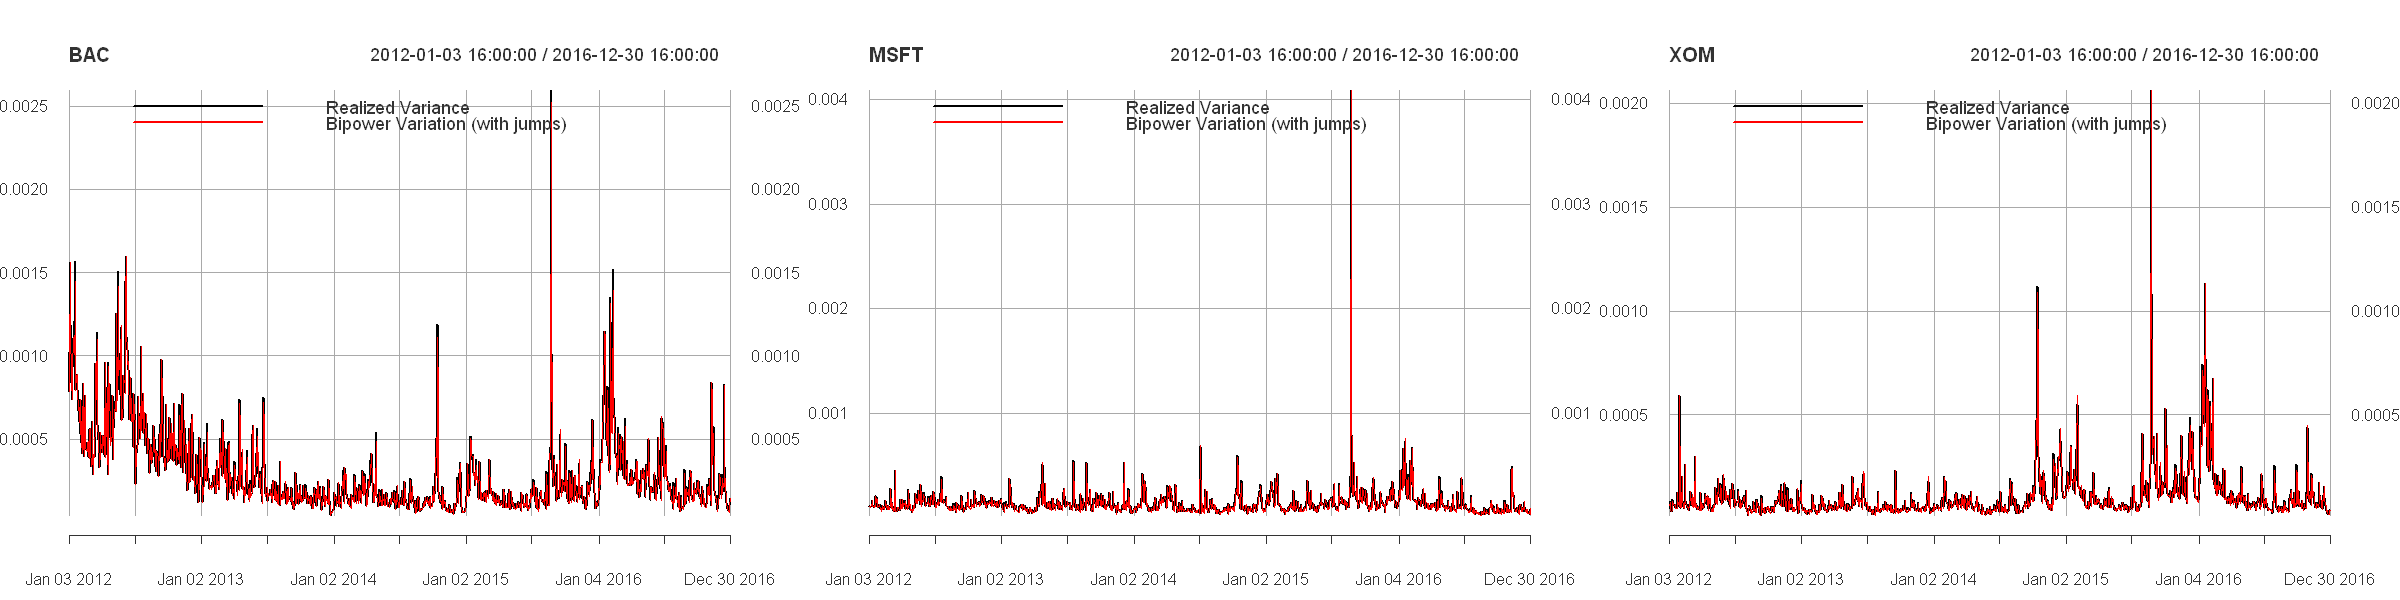

In [30]:
#Plotting RV vs BPV with jumps
par(mfrow = c(1, 3))
for (i in 1:3) {
    plot_holder <- plot(real_var_from_prices[[i]], main = stock_names[i])
    plot_holder <- lines(bpv[[i]] + jumps_signif[[i]], col = "red")
    plot_holder <- addLegend("topleft", on = 1, legend.names = c("Realized Variance", "Bipower Variation (with jumps)"), col = c("black", "red"), lty = 1, bty = "n", lwd = 2)
    print(plot_holder)
}

### 10.

In this section we try to find an appropriate ARMA model for each stock. Subsequently, we estimate GARCH(1, 1) and compare the estimated volatility with Realized Volatility. Firstly, we calculate the daily returns as a sum of the previously derived intraday returns for each day.

In [26]:
#Calculating daily returns
daily_returns <- vector("list", 3) #Empty list for the daily returns
for (i in 1:3) {
    daily_returns[[i]] <- to.daily(apply.daily(na.omit(hw3_data_final[[i]]), sum), OHLC = F) #to.daily removes the time stamp
}

In [18]:
#Calculating daily returns
daily_returns <- vector("list", 3) #Empty list for the daily returns
for (i in 1:3) {
    daily_prices <- to.daily(hw3_data_restricted[[i]], OHLC = F) #Converting minute data to daily data
    daily_returns[[i]] <- na.omit(makeReturns_adjusted(daily_prices)) #Calculating the returns (NA as a first obs rather than 0) and then removing NAs since some of the functions cannot deal with them
}

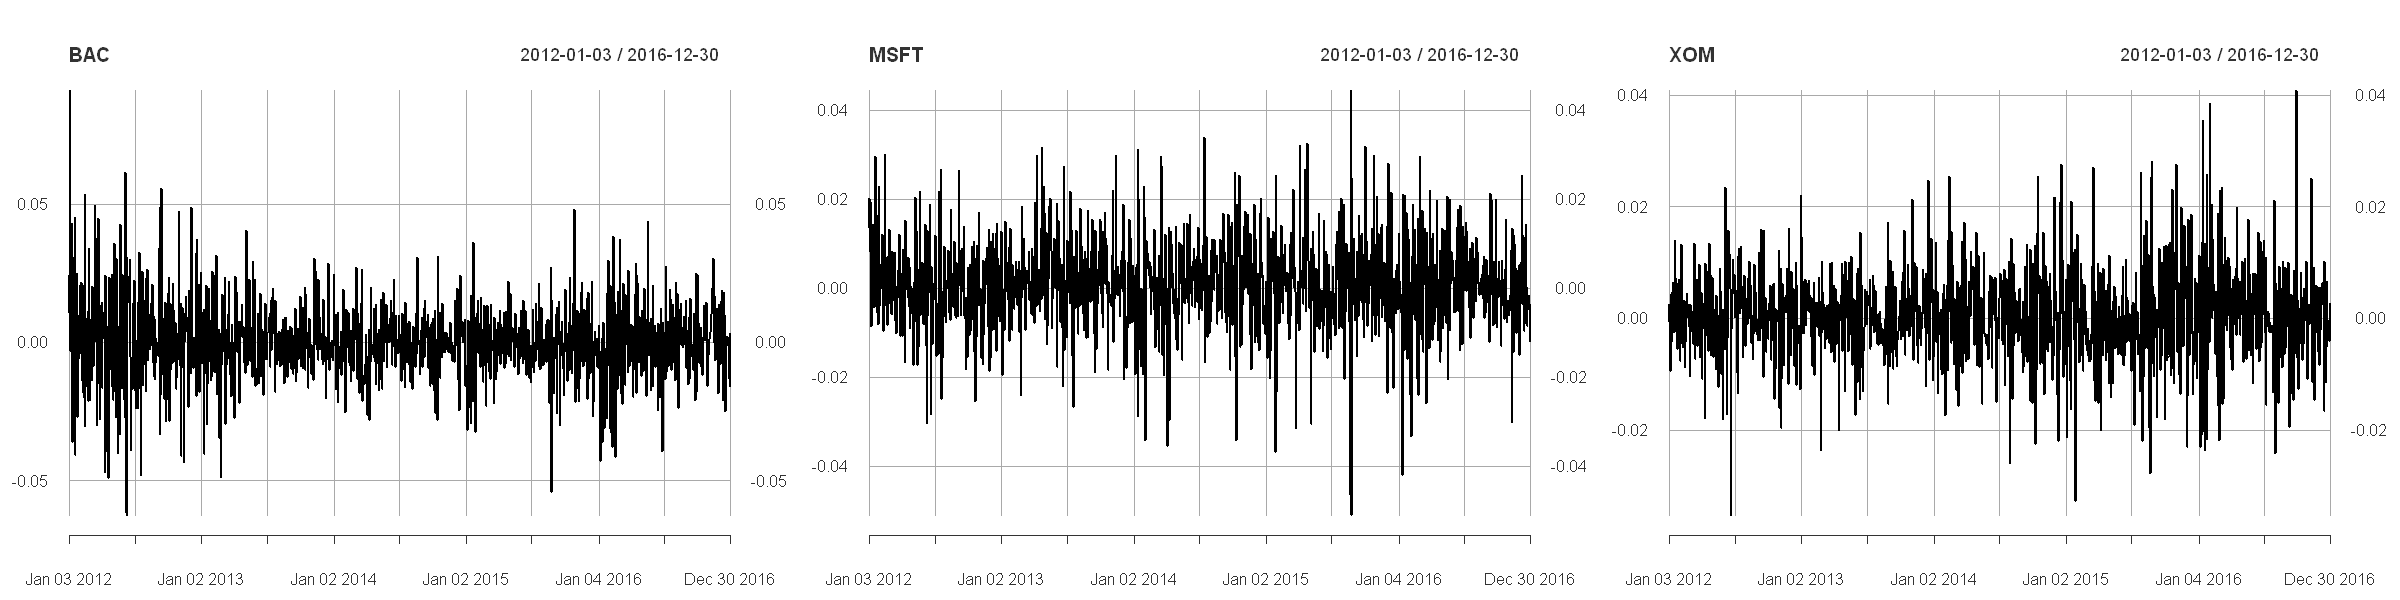

In [27]:
#Plotting the daily returns
options(repr.plot.width = 20, repr.plot.height = 5)
par(mfrow = c(1, 3))
for (i in 1:3) {
    print(plot(daily_returns[[i]], main = stock_names[i]))
}

As can be seen from the plots, the series of returns for each stock seem to be mean-stationary. However, we can observe some variance clustering. We will test whether the series are stationary using the Augmented Dickey-Fuller test.

In [13]:
#Augmented Dickey-Fuller Test
for (i in 1:3) {
    print(stock_names[i])
    print(adf.test(daily_returns[[i]]))
}

[1] "BAC"


Warning message in adf.test(daily_returns[[i]]):
"p-value smaller than printed p-value"



	Augmented Dickey-Fuller Test

data:  daily_returns[[i]]
Dickey-Fuller = -10.234, Lag order = 10, p-value = 0.01
alternative hypothesis: stationary

[1] "MSFT"


Warning message in adf.test(daily_returns[[i]]):
"p-value smaller than printed p-value"



	Augmented Dickey-Fuller Test

data:  daily_returns[[i]]
Dickey-Fuller = -10.432, Lag order = 10, p-value = 0.01
alternative hypothesis: stationary

[1] "XOM"


Warning message in adf.test(daily_returns[[i]]):
"p-value smaller than printed p-value"



	Augmented Dickey-Fuller Test

data:  daily_returns[[i]]
Dickey-Fuller = -11.875, Lag order = 10, p-value = 0.01
alternative hypothesis: stationary



As the results suggest, the null hypothesis of the presence of the unit root is rejected in favor of the alternative of stationarity for all three stocks. Therefore, we can proceed with the inspection of the Autocorrelation Function and Partial-Autocorrelation Function.

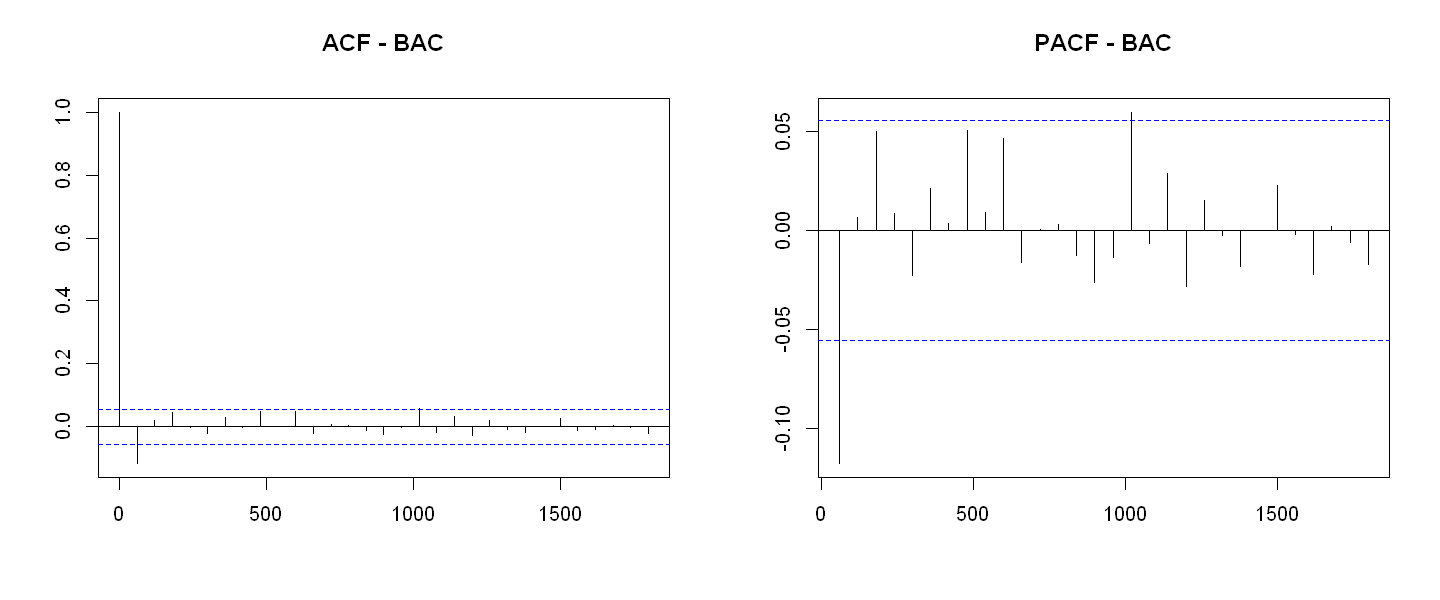

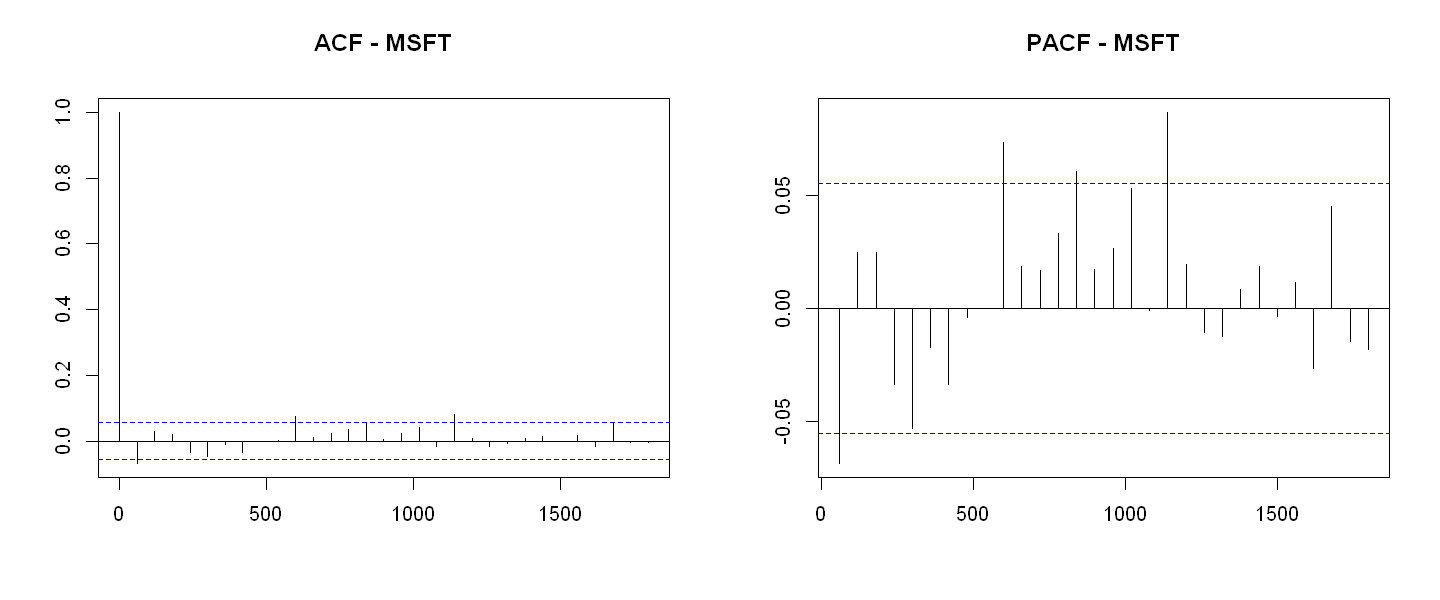

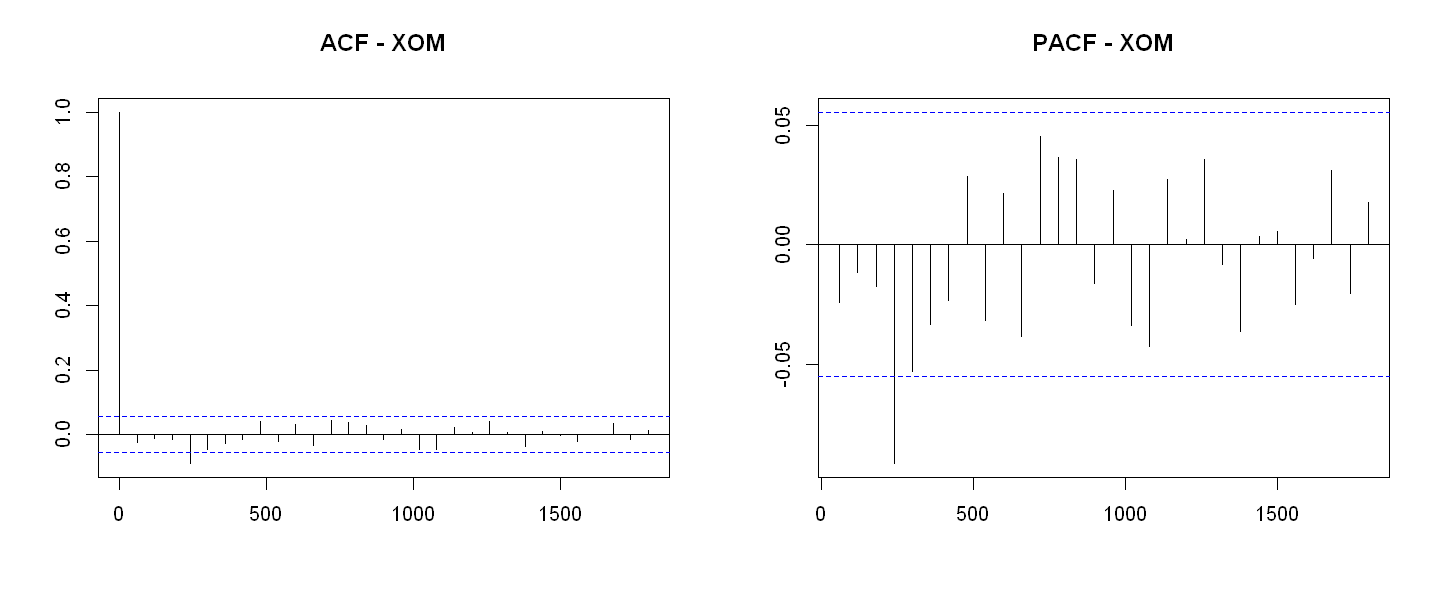

In [14]:
#ACF and PACF
options(repr.plot.width = 12, repr.plot.height = 5)
par(mfrow = c(1, 2))
for (i in 1:3) {
    acf(daily_returns[[i]], xlab = "", ylab = "", main = paste("ACF", "-", stock_names[i]))
    pacf(daily_returns[[i]], xlab = "", ylab = "", main = paste("PACF", "-", stock_names[i]))
}

The ACF and PACF suggest that there are only a few significant dependencies. We could possibly be able to model these using only GARCH. However, we perform a Ljung-Box test to confirm our suspicions.

In [15]:
#Ljung-Box test
for (i in 1:3) {
    print(stock_names[i])
    for (lag_order in c(4, 8, 12)) {
        print(Box.test(daily_returns[[i]], type = "Ljung-Box", lag = lag_order)$p.value)
    }
}

[1] "BAC"
[1] 0.0003758492
[1] 0.001467492
[1] 0.004343892
[1] "MSFT"
[1] 0.0566545
[1] 0.08872023
[1] 0.04157217
[1] "XOM"
[1] 0.02095421
[1] 0.02249072
[1] 0.02410091


The results of the test indicate that there are some significant autocorrelations for MSFT and XOM (at the 10% significance level). Instead of inspecting both stocks separately, we can utilize the ``auto.arima`` function which finds the optimal ARMA model based on information criteria. Its output needs to of course be treated with caution.

In [17]:
#Finding the optimal ARMA model
for (i in 1:3) {
    print(stock_names[i])
    for (inf_crit in c("aic","aicc","bic")) {
        auto_model <- auto.arima(daily_returns[[i]], stationary = T, ic = inf_crit) 
        print(paste(inf_crit, ": ", "ARMA(", auto_model$arma[1], ",", auto_model$arma[2], ")", sep = ""), quote = F)
    }
}

[1] "BAC"
[1] aic: ARMA(3,0)
[1] aicc: ARMA(3,0)
[1] bic: ARMA(3,0)
[1] "MSFT"
[1] aic: ARMA(1,2)
[1] aicc: ARMA(1,2)
[1] bic: ARMA(0,0)
[1] "XOM"
[1] aic: ARMA(0,0)
[1] aicc: ARMA(0,0)
[1] bic: ARMA(0,0)


As can be seen, the best model for both stocks appears to be ARMA(0, 0). Therefore, our intial assumption that we can model the dependencies using GARCH might be correct. We can proceed with modelling GARCH(1, 1). An initial attempt showed that the optimization fails to converge for MSFT despite trying to use various solvers. Therefore, we changed the specification to GARCH(2,1). 

In [28]:
#Estimating GARCH(1, 1)
garch_vol <- vector("list", 3) #Empty vector for the estimated volatilities
garchspecother <- ugarchspec(variance.model = list(model = "sGARCH", garchOrder = c(1, 1)), #Saving the specifications since they are shared among the two stocks
                        mean.model = list(armaOrder = c(0, 0), include.mean = TRUE, archm = TRUE, archpow = 1))
garchspecMSFT <- ugarchspec(variance.model = list(model = "sGARCH", garchOrder = c(1, 1)), #Saving the specifications for MSFT
                        mean.model = list(armaOrder = c(0, 0), include.mean = TRUE, archm = TRUE, archpow = 1))

for (i in 1:3) {
    if (i == 2) {
        garchspec <- garchspecMSFT
    } else {
        garchspec <- garchspecother
    }
    garch_vol[[i]] <- sigma(ugarchfit(garchspec, daily_returns[[i]])) #Estimating GARCH(1, 1) and storing the volatility
}

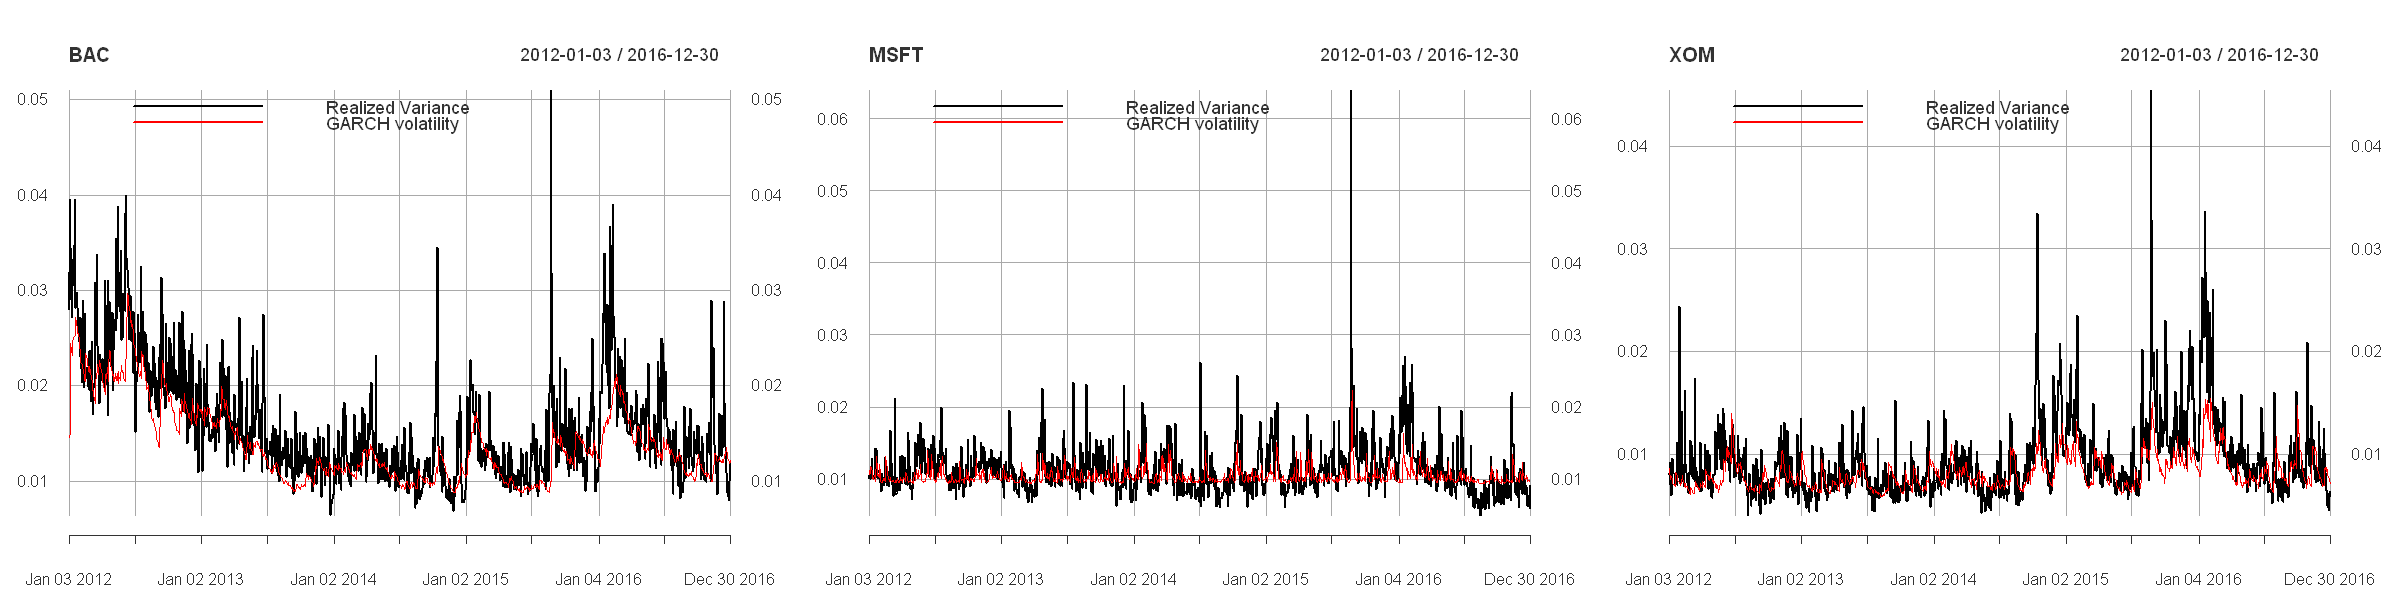

In [29]:
#Plotting estimated GARCH volatility vs Realized Volatility
options(repr.plot.width = 20, repr.plot.height = 5)
par(mfrow = c(1, 3))
for (i in 1:3) {
    plot_holder <- plot(sqrt(to.daily(real_var_from_returns[[i]], OHLC = F)), main = stock_names[i])
    plot_holder <- lines(garch_vol[[i]], col = "red")
    plot_holder <- addLegend("topleft", on = 1, legend.names = c("Realized Variance", "GARCH volatility"), col = c("black", "red"), lty = 1, bty = "n", lwd = 2)
    print(plot_holder)
}

As the plots suggest, the estimated GARCH volatility is quite similar to Realized Volatility in case of BAC and XOM. Even though, the estimates are a bit shifted (which is intuitive given the nature of the model), they seem to fit well. A different scenario can be observed for MSFT, where GARCH is doing a very poor job. As mentioned above, the estimator even failed to converge which suggest that there might be some issues with the data or the variance of MSFT returns is difficult to predict.